# Physics-Informed Neural Network for 1D Heat Equation

## Problem Setup
We solve: $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

 - **Forward Problem**: Given $\alpha$, find $u(x,t)$
 - **Inverse Problem**: Given measurements of $u$, find $\alpha$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from models.heat_pinn import HeatPINN, analytical_solution
from data.heat_data import HeatEquationData
from training.trainer import PINNTrainer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Imports successful.")

Imports successful.


## Step 1: Generate Data

Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 40.3 dB

Dataset generation complete.


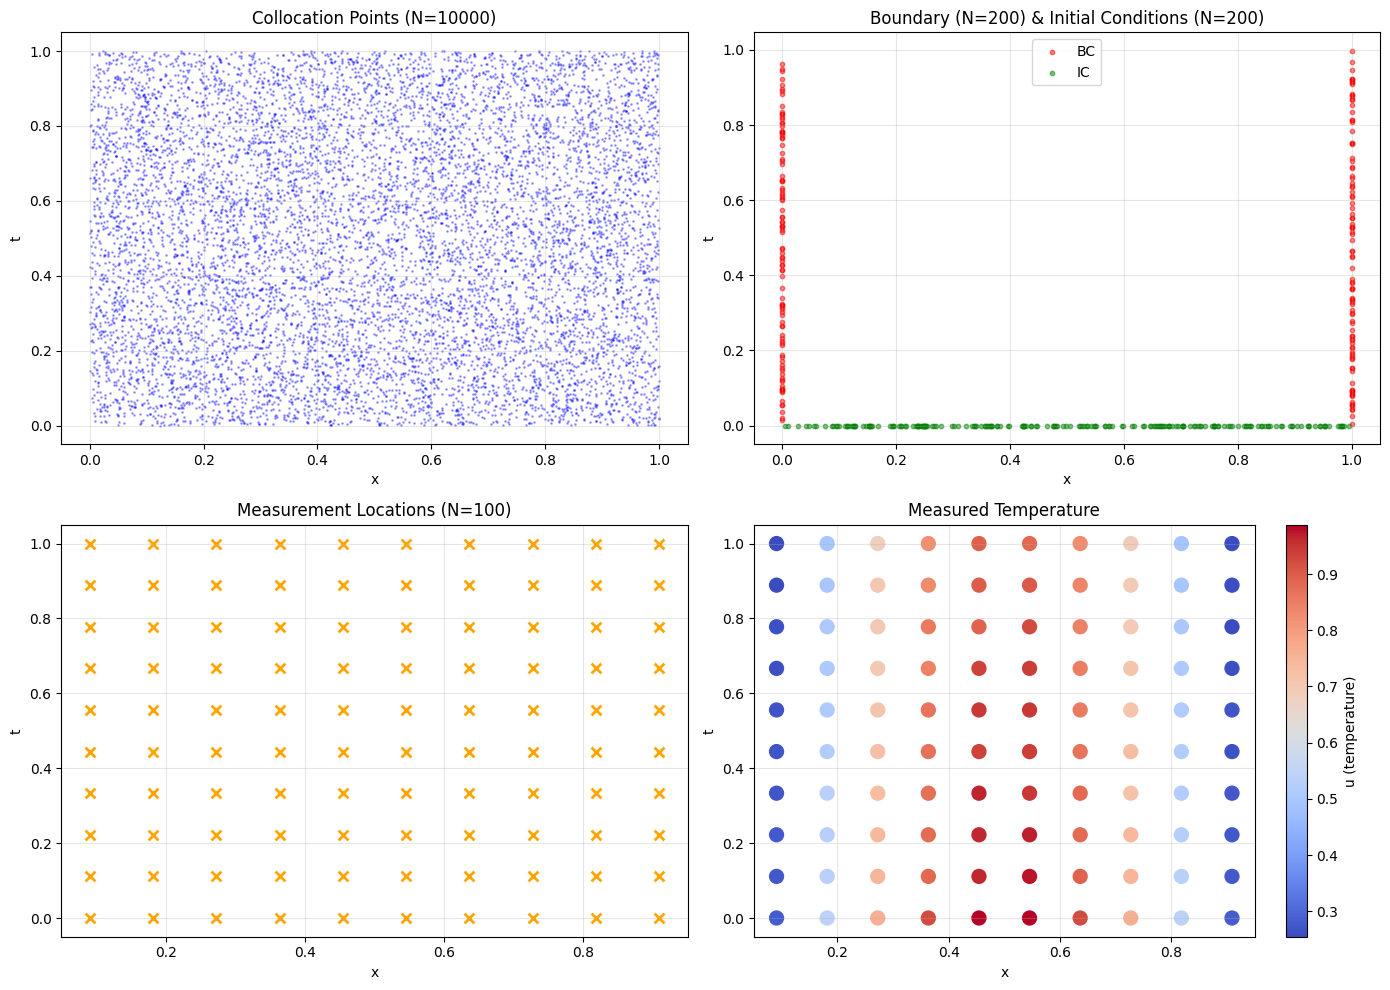

In [2]:
data_gen = HeatEquationData(
    L=1.0,                  # Domain length
    T=1.0,                  # Final time
    alpha=0.01,             # True thermal diffusivity
    N_f=10000,              # Collocation points
    N_bc = 100,             # BC points
    N_ic = 200,             # IC points
    N_sensors=10,           # Sensor locations
    N_time_measurements=10, # Time measurements
    noise_level=0.01,       # 1% noise (SNR ~ 40 dB)
    device='cpu'
)

# Generate complete dataset
data = data_gen.generate_full_dataset(collocation_method='uniform')

# Visualize the data
data_gen.visualize_data(data)

## Step 2: Train Forward Problem

Here we solve for $u(x,t)$ given known $\alpha = 0.01$

### Fixed weights *without* L-BFGS

In [3]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

print(f"Model parameters: {sum(p.numel() for p in model_forward.parameters())}")

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 1e-12
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 7.799184e-01
  Residual: 3.642399e-04 (λ=1.00)
  Boundary: 4.342730e-02 (λ=1.00)
  Initial: 7.361268e-01 (λ=1.00)

Epoch 1000/5000 (53.4s)
  Total Loss: 2.935953e-04
  Residual: 1.056388e-04 (λ=1.00)
  Boundary: 6.532913e-05 (λ=1.00)
  Initial: 1.226274e-04 (λ=1.00)

Epoch 2000/5000 (107.9s)
  Total Loss: 6.808015e-05
  Residual: 2.574606e-05 (λ=1.00)
  Boundary: 1.277820e-05 (λ=1.00)
  Initial: 2.955589e-05 (λ=1.00)


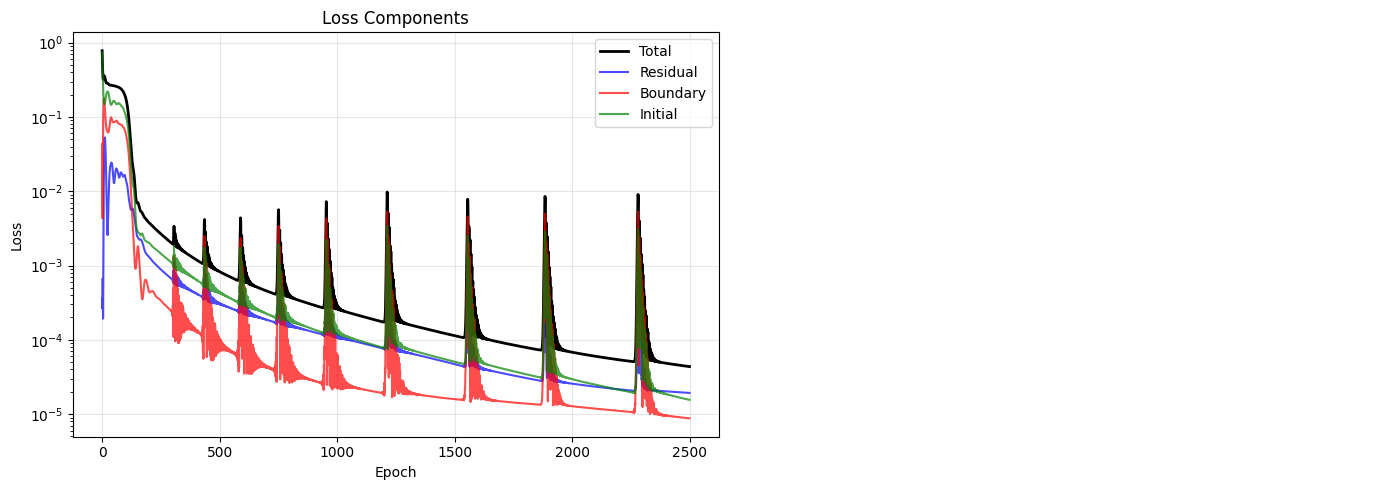


Epoch 3000/5000 (165.1s)
  Total Loss: 2.980997e-05
  Residual: 1.610084e-05 (λ=1.00)
  Boundary: 5.493638e-06 (λ=1.00)
  Initial: 8.215499e-06 (λ=1.00)

Epoch 4000/5000 (217.1s)
  Total Loss: 1.638878e-05
  Residual: 1.168227e-05 (λ=1.00)
  Boundary: 1.937412e-06 (λ=1.00)
  Initial: 2.769101e-06 (λ=1.00)

Final training plot:


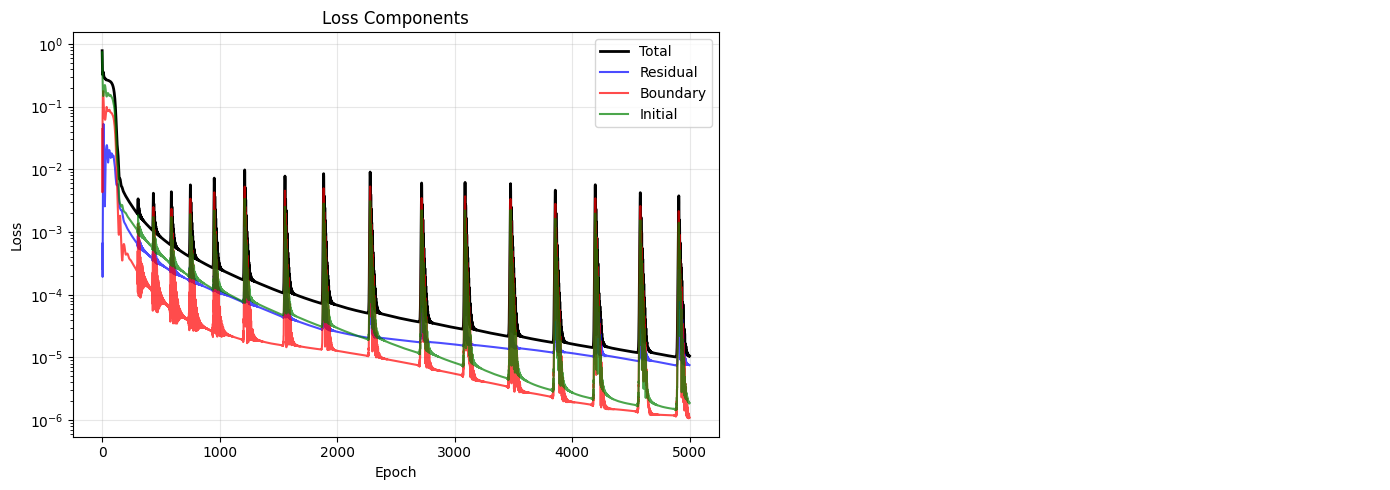


Training complete. Total time: 267.5s


In [4]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_threshold=1e-12, # very low = disabled
    track_gradient_norms=False,
    adaptive_weights=False,
)

# Train for 5000 epochs
trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

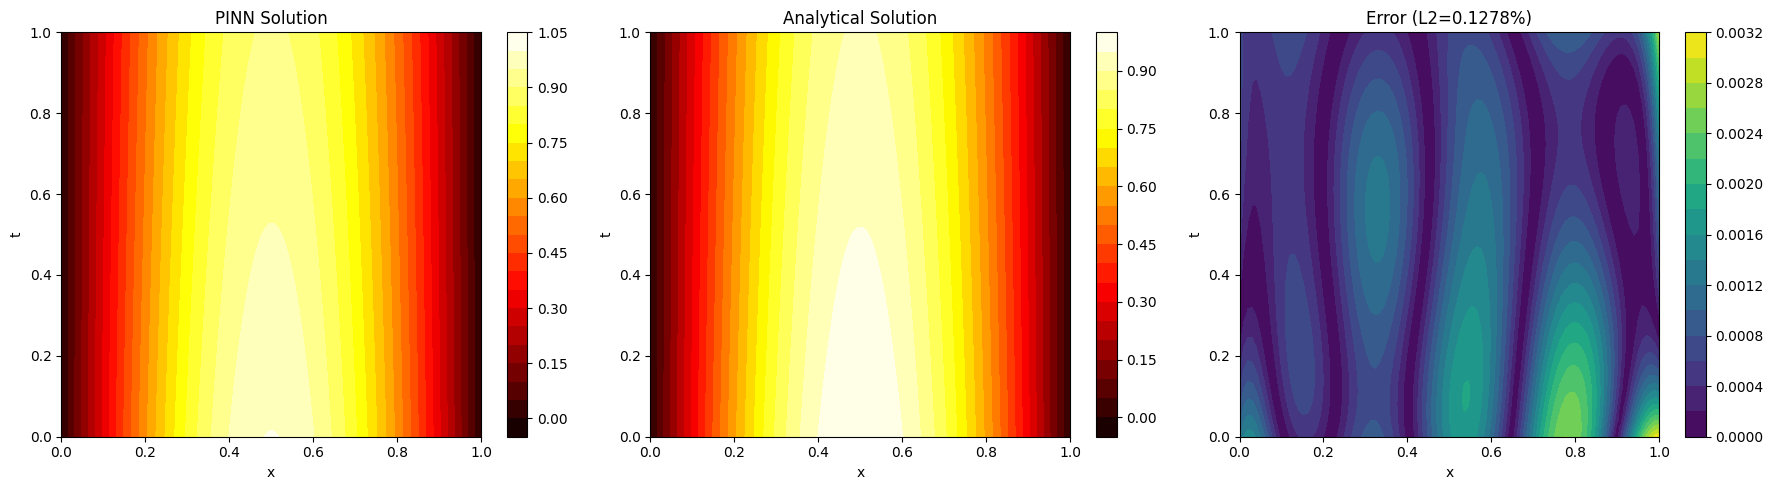

In [5]:
x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

x_flat = X.flatten().reshape(-1, 1)
t_flat = T.flatten().reshape(-1, 1)

# PINN prediction
u_pred = model_forward.predict(x_flat, t_flat).reshape(100, 100)

# Analytical solution
u_exact = analytical_solution(x_flat.numpy(), t_flat.numpy(), alpha=0.01).reshape(100, 100)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].contourf(X.numpy(), T.numpy(), u_pred, levels=20, cmap='hot')
axes[0].set_title('PINN Solution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].contourf(X.numpy(), T.numpy(), u_exact, levels=20, cmap='hot')
axes[1].set_title('Analytical Solution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
plt.colorbar(im2, ax=axes[1])

error = np.abs(u_pred - u_exact)
im3 = axes[2].contourf(X.numpy(), T.numpy(), error, levels=20, cmap='viridis')
axes[2].set_title(f'Error (L2={np.sqrt(np.sum((u_pred - u_exact)**2)) / np.sqrt(np.sum(u_exact**2)) * 100:.4f}%)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

### Fixed weights with L-BFGS

In [6]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

print(f"Model parameters: {sum(p.numel() for p in model_forward.parameters())}")

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 8.925540e-01
  Residual: 7.416567e-02 (λ=1.00)
  Boundary: 9.310022e-02 (λ=1.00)
  Initial: 7.252881e-01 (λ=1.00)

Switching to L-BFGS at epoch 851

Final training plot:


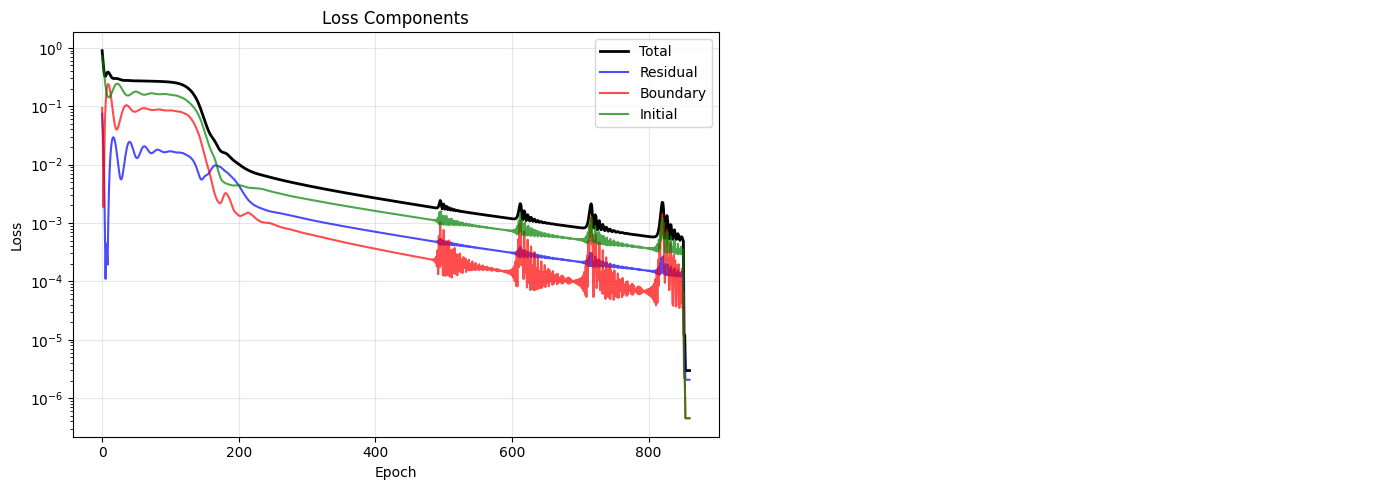


Training complete. Total time: 51.4s


In [7]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_threshold=5e-4,
    track_gradient_norms=False,
    adaptive_weights=False,
)

# Train for 5000 epochs
trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

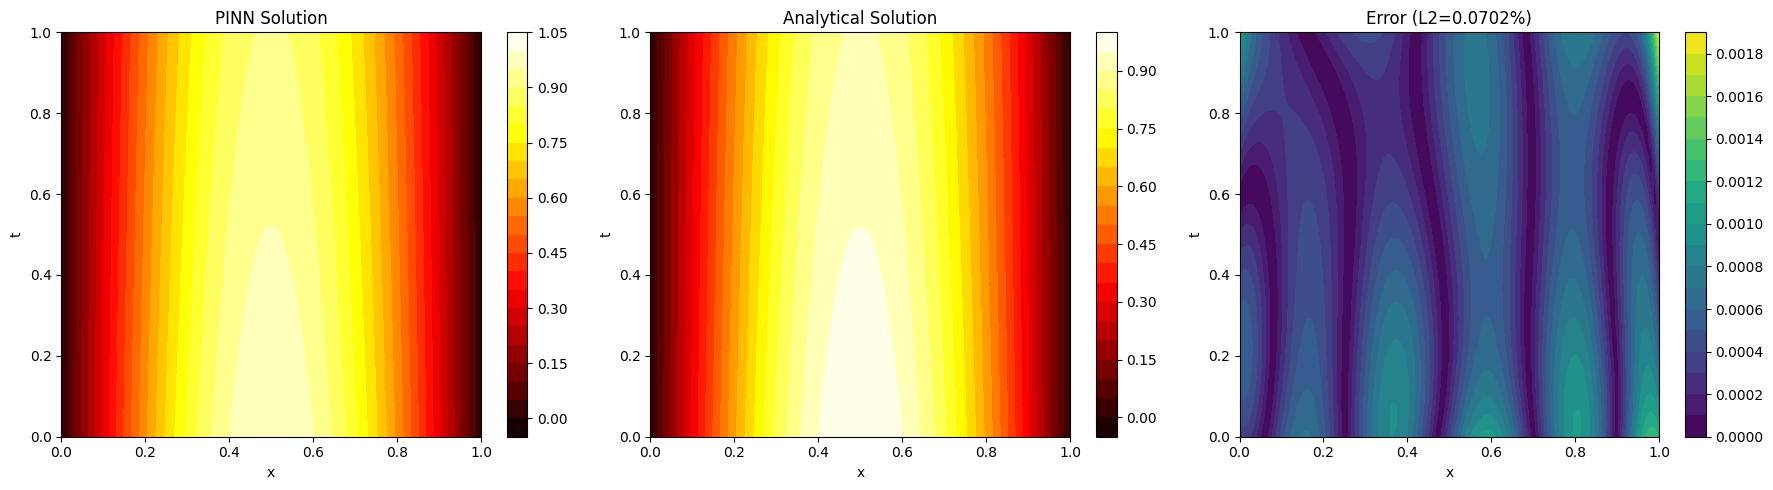

In [8]:
x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

x_flat = X.flatten().reshape(-1, 1)
t_flat = T.flatten().reshape(-1, 1)

# PINN prediction
u_pred = model_forward.predict(x_flat, t_flat).reshape(100, 100)

# Analytical solution
u_exact = analytical_solution(x_flat.numpy(), t_flat.numpy(), alpha=0.01).reshape(100, 100)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].contourf(X.numpy(), T.numpy(), u_pred, levels=20, cmap='hot')
axes[0].set_title('PINN Solution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].contourf(X.numpy(), T.numpy(), u_exact, levels=20, cmap='hot')
axes[1].set_title('Analytical Solution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
plt.colorbar(im2, ax=axes[1])

error = np.abs(u_pred - u_exact)
im3 = axes[2].contourf(X.numpy(), T.numpy(), error, levels=20, cmap='viridis')
axes[2].set_title(f'Error (L2={np.sqrt(np.sum((u_pred - u_exact)**2)) / np.sqrt(np.sum(u_exact**2)) * 100:.4f}%)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

### Advantage of L-BFGS

We train the same model with Adam up to the epoch where L-BFGS kicked in and compare the prediction errors

In [9]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

print(f"Model parameters: {sum(p.numel() for p in model_forward.parameters())}")

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 1e-12
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/860 (0.1s)
  Total Loss: 7.230464e-01
  Residual: 1.001111e-04 (λ=1.00)
  Boundary: 2.650975e-02 (λ=1.00)
  Initial: 6.964365e-01 (λ=1.00)

Epoch 500/860 (24.1s)
  Total Loss: 1.324155e-03
  Residual: 5.300161e-04 (λ=1.00)
  Boundary: 1.494632e-04 (λ=1.00)
  Initial: 6.446759e-04 (λ=1.00)

Final training plot:


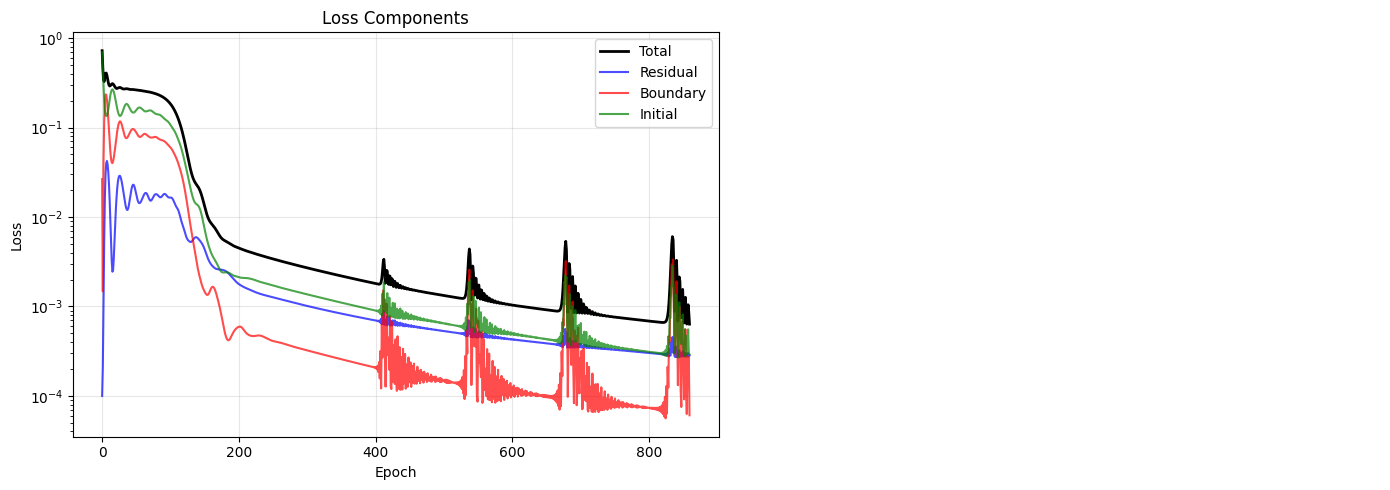


Training complete. Total time: 45.9s


In [10]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_threshold=1e-12,
    track_gradient_norms=False,
    adaptive_weights=False,
)

# Train for L-BFGS epochs
trainer_forward.train(
    epochs=860,
    print_every=500,
    plot_every=1000
)

Visualize

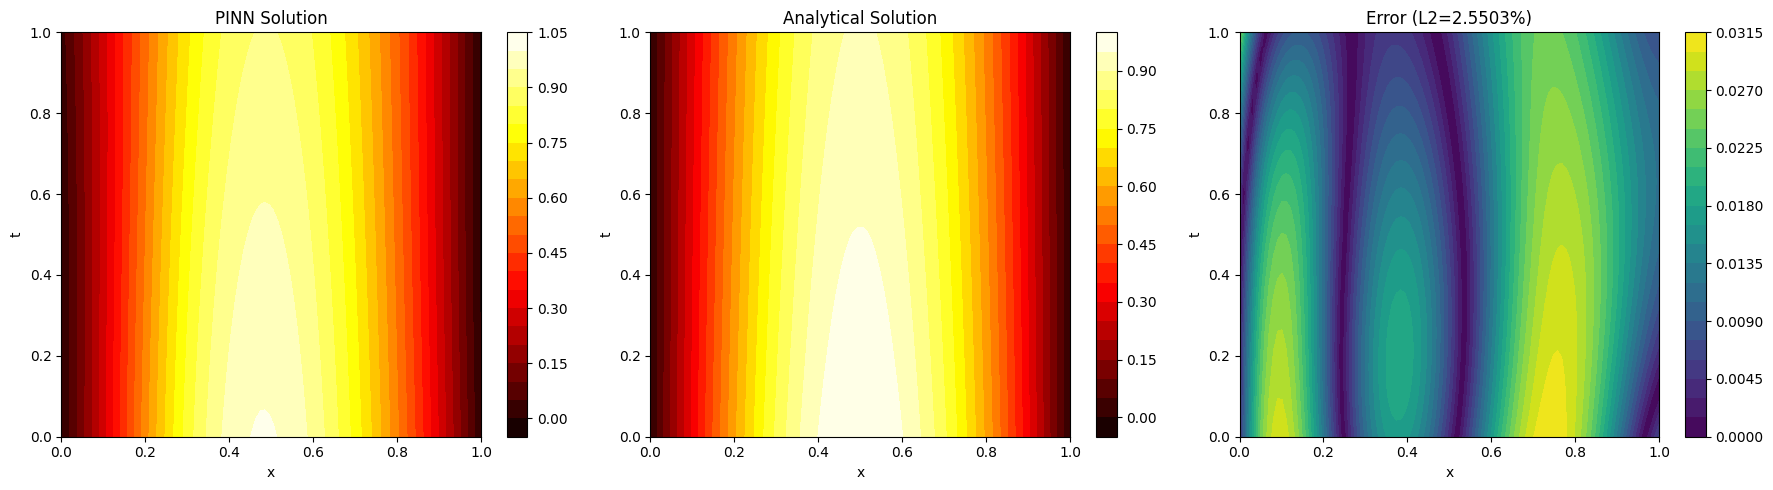

In [11]:
x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

x_flat = X.flatten().reshape(-1, 1)
t_flat = T.flatten().reshape(-1, 1)

# PINN prediction
u_pred = model_forward.predict(x_flat, t_flat).reshape(100, 100)

# Analytical solution
u_exact = analytical_solution(x_flat.numpy(), t_flat.numpy(), alpha=0.01).reshape(100, 100)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].contourf(X.numpy(), T.numpy(), u_pred, levels=20, cmap='hot')
axes[0].set_title('PINN Solution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].contourf(X.numpy(), T.numpy(), u_exact, levels=20, cmap='hot')
axes[1].set_title('Analytical Solution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
plt.colorbar(im2, ax=axes[1])

error = np.abs(u_pred - u_exact)
im3 = axes[2].contourf(X.numpy(), T.numpy(), error, levels=20, cmap='viridis')
axes[2].set_title(f'Error (L2={np.sqrt(np.sum((u_pred - u_exact)**2)) / np.sqrt(np.sum(u_exact**2)) * 100:.4f}%)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

**Conclusion**: L-BFGS improves the L2 error of the solution by a factor of $\approx 35$ for the same training time!

### Identifying the cause of spikes

The training loss curves display spikes when the optimizer starts probing high-curvature regions of the parameter landscape (weight, bias). In these regions the losses increase, which causes the optimizer to steer away from them.

These high-curvature regions are related to high eigenvalues of the losses' Hessian matrix, which can be inferred from the presence of spikes in the loss gradients.

In [15]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

print(f"Model parameters: {sum(p.numel() for p in model_forward.parameters())}")

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 1e-12
  Tracking gradient L2 norms: True
  Adaptive weights: False
  Problem type: Forward

Starting training...

Epoch 0/2000 (0.1s)
  Total Loss: 5.319207e-01
  Residual: 9.473966e-06 (λ=1.00)
  Boundary: 3.576551e-04 (λ=1.00)
  Initial: 5.315536e-01 (λ=1.00)

Epoch 1000/2000 (111.1s)
  Total Loss: 1.325854e-04
  Residual: 6.363541e-05 (λ=1.00)
  Boundary: 1.286716e-05 (λ=1.00)
  Initial: 5.608285e-05 (λ=1.00)


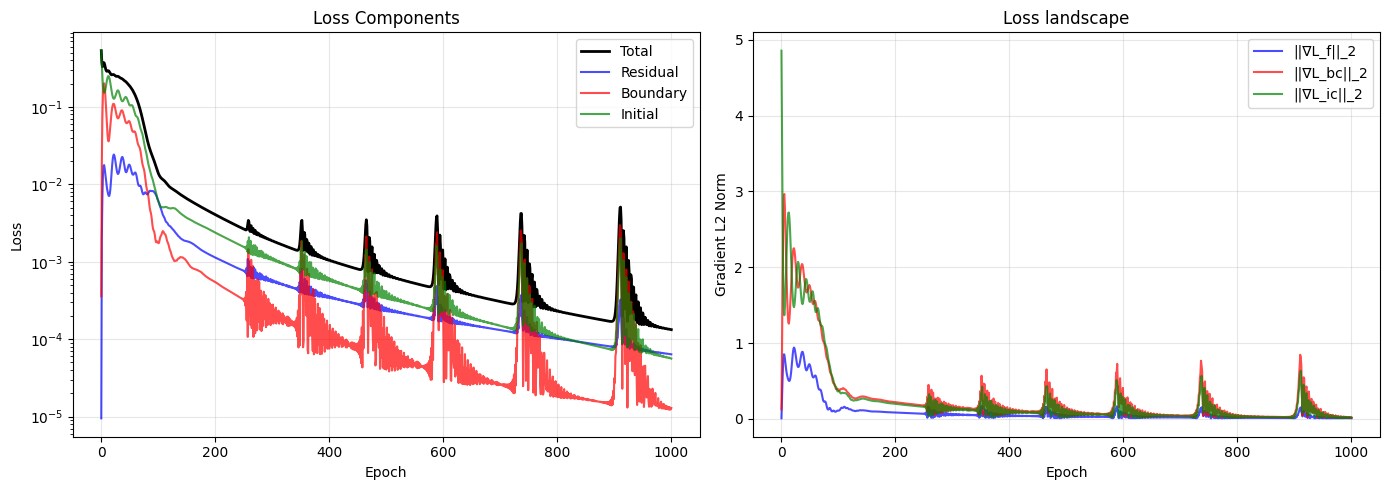


Final training plot:


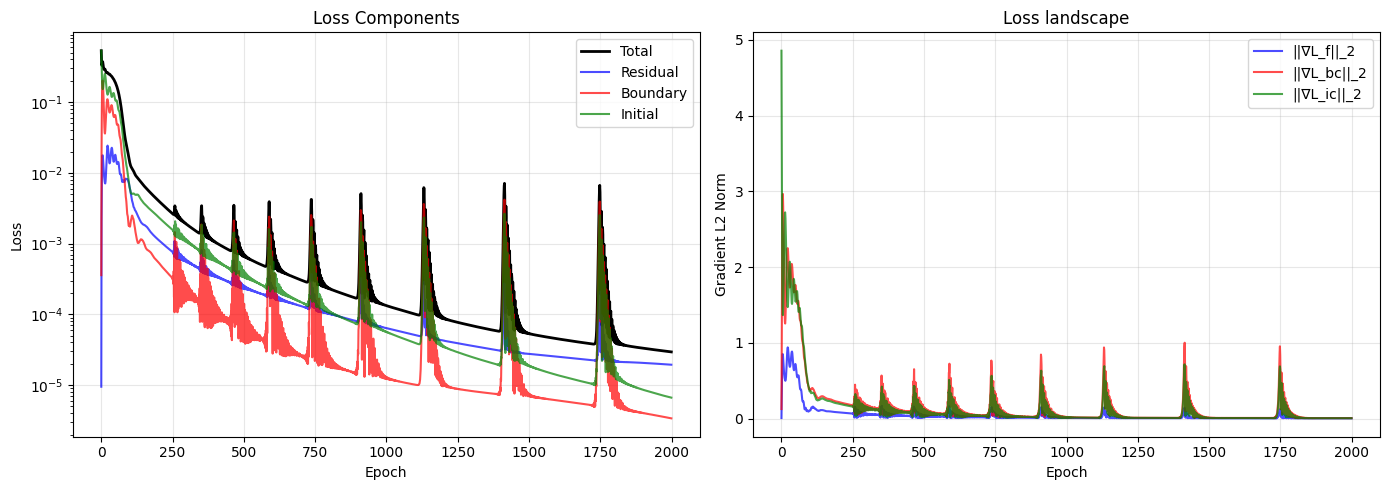


Training complete. Total time: 224.4s


In [16]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_threshold=1e-12,
    track_gradient_norms=True,
    adaptive_weights=False,
)

# Train for 2000 epochs
trainer_forward.train(
    epochs=2000,
    print_every=1000,
    plot_every=1000
)

### Effect of adaptive weights

In [17]:
model_forward = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01,
    inverse=False
)

print(f"Model parameters: {sum(p.numel() for p in model_forward.parameters())}")

Forward problem mode: alpha fixed to 0.01
Model parameters: 7851


We use L-BFGS since it has proven effective

Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 6.025344e-01
  Residual: 1.733574e-02 (λ=1.00)
  Boundary: 4.391146e-03 (λ=1.00)
  Initial: 5.808074e-01 (λ=1.00)

Switching to L-BFGS at epoch 546

Final training plot:


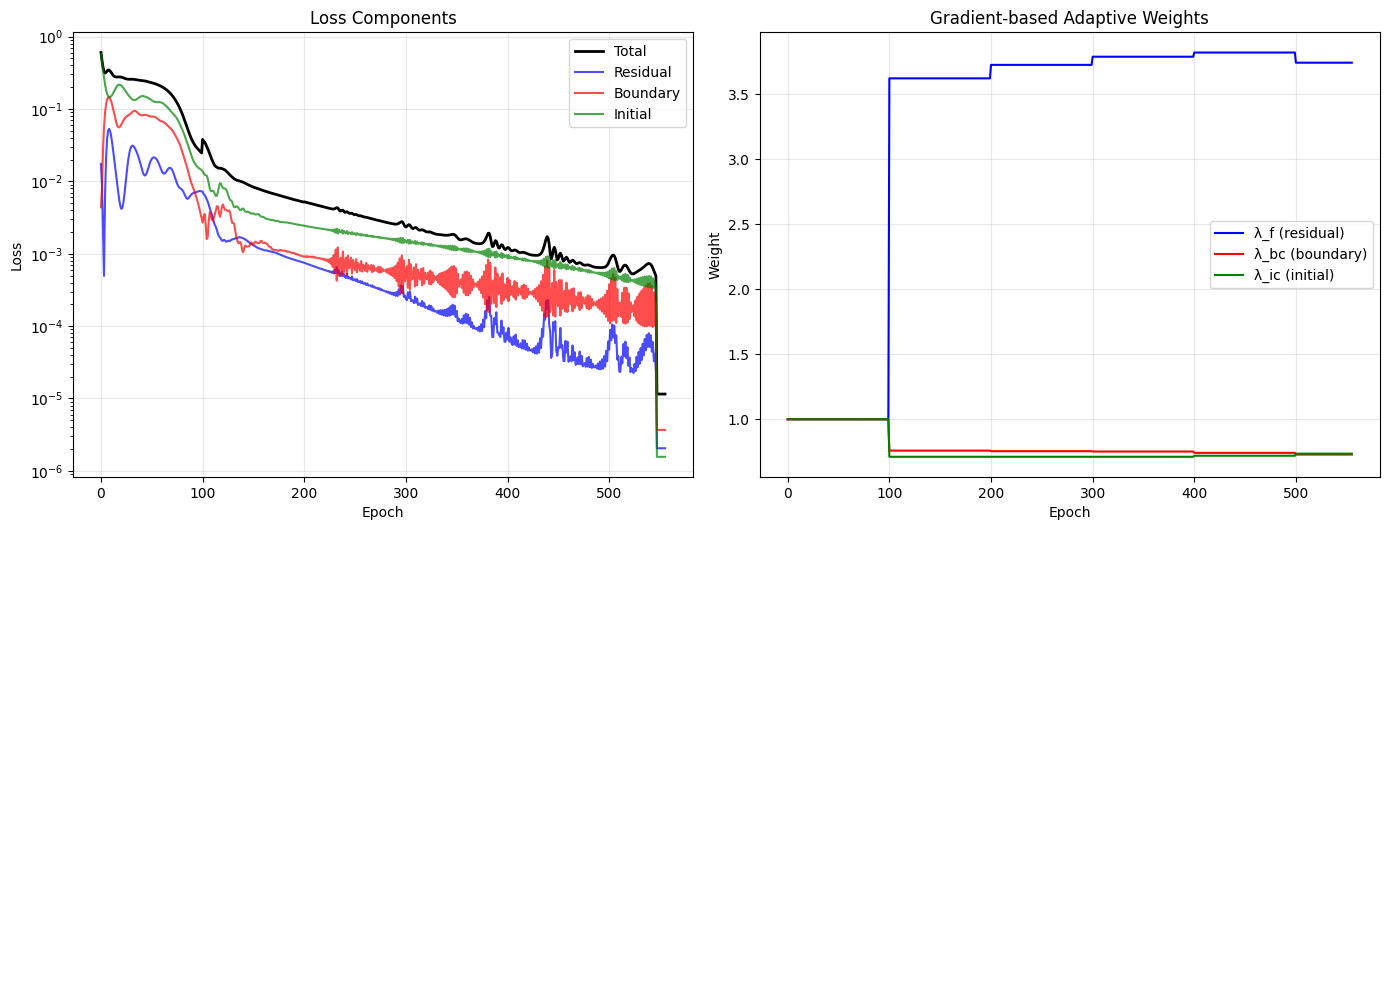


Training complete. Total time: 42.0s


In [18]:
trainer_forward = PINNTrainer(
    model=model_forward,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_threshold=5e-4,
    track_gradient_norms=False,
    adaptive_weights=True,
)

# Train for 5000 epochs
trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Visualize

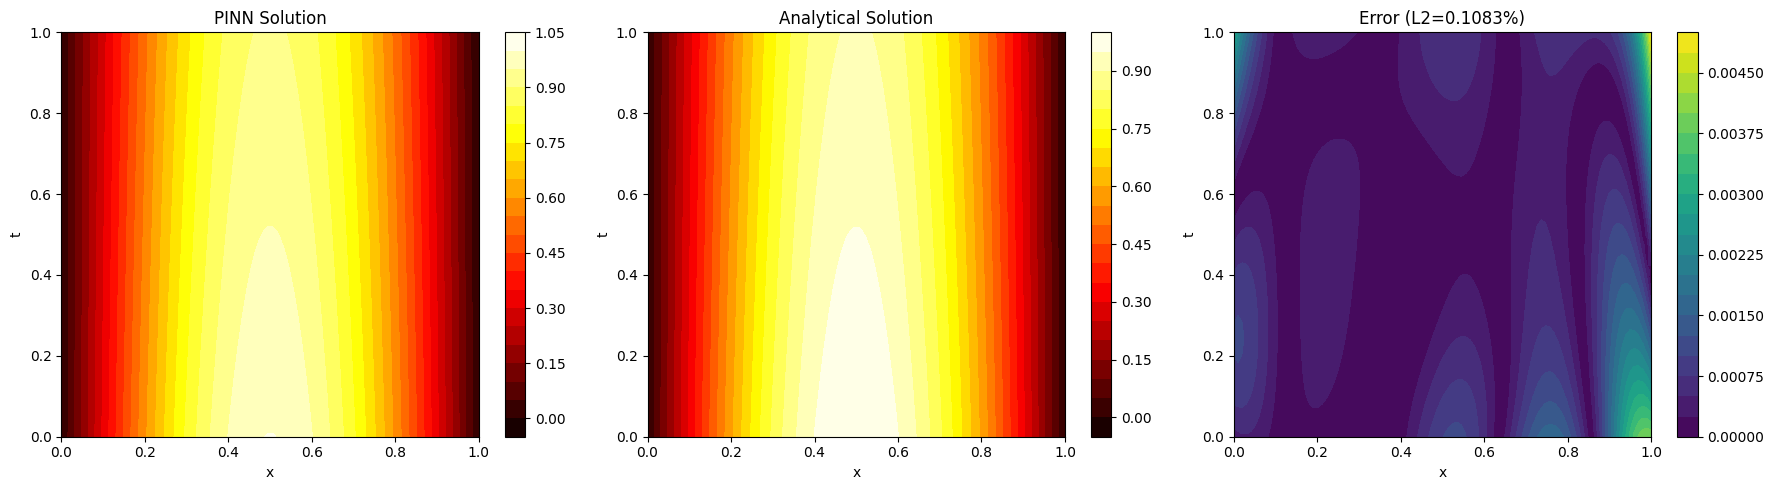

In [19]:
x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

x_flat = X.flatten().reshape(-1, 1)
t_flat = T.flatten().reshape(-1, 1)

# PINN prediction
u_pred = model_forward.predict(x_flat, t_flat).reshape(100, 100)

# Analytical solution
u_exact = analytical_solution(x_flat.numpy(), t_flat.numpy(), alpha=0.01).reshape(100, 100)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].contourf(X.numpy(), T.numpy(), u_pred, levels=20, cmap='hot')
axes[0].set_title('PINN Solution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].contourf(X.numpy(), T.numpy(), u_exact, levels=20, cmap='hot')
axes[1].set_title('Analytical Solution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
plt.colorbar(im2, ax=axes[1])

error = np.abs(u_pred - u_exact)
im3 = axes[2].contourf(X.numpy(), T.numpy(), error, levels=20, cmap='viridis')
axes[2].set_title(f'Error (L2={np.sqrt(np.sum(error**2)) / np.sqrt(np.sum(u_exact**2)) * 100:.4f}%)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

**Conclusion**: adaptive weights do not help. This is likely due to the fact that the PDE is smooth and does not display multi-scale or high-frequency features.

## Step 3: Train Inverse Problem

Now we recover $\alpha$ from noisy measurements of $u(x,t)$

### Fixed weights without L-BFGS

In [ ]:
model_inverse = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02  # Initial guess
)

print(f"Initial alpha guess: {model_inverse.get_alpha():.6f}")
print(f"True alpha: 0.01")

Inverse problem mode: alpha initialized to 0.02
Initial alpha guess: 0.020000
True alpha: 0.01


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 1e-12
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.153468e+00
  Residual: 2.045368e-01 (λ=1.00)
  Boundary: 4.624955e-02 (λ=1.00)
  Initial: 5.826653e-01 (λ=1.00)
  Measurement: 3.200167e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 1000/5000 (59.7s)
  Total Loss: 7.482230e-04
  Residual: 2.753626e-04 (λ=1.00)
  Boundary: 6.204593e-05 (λ=1.00)
  Initial: 1.944742e-04 (λ=1.00)
  Measurement: 2.163403e-04 (λ=1.00)
  Alpha: 0.008216 (true: 0.01)

Epoch 2000/5000 (120.6s)
  Total Loss: 2.647683e-04
  Residual: 9.973849e-05 (λ=1.00)
  Boundary: 1.971663e-05 (λ=1.00)
  Initial: 5.711189e-05 (λ=1.00)
  Measurement: 8.820134e-05 (λ=1.00)
  Alpha: 0.009437 (true: 0.01)


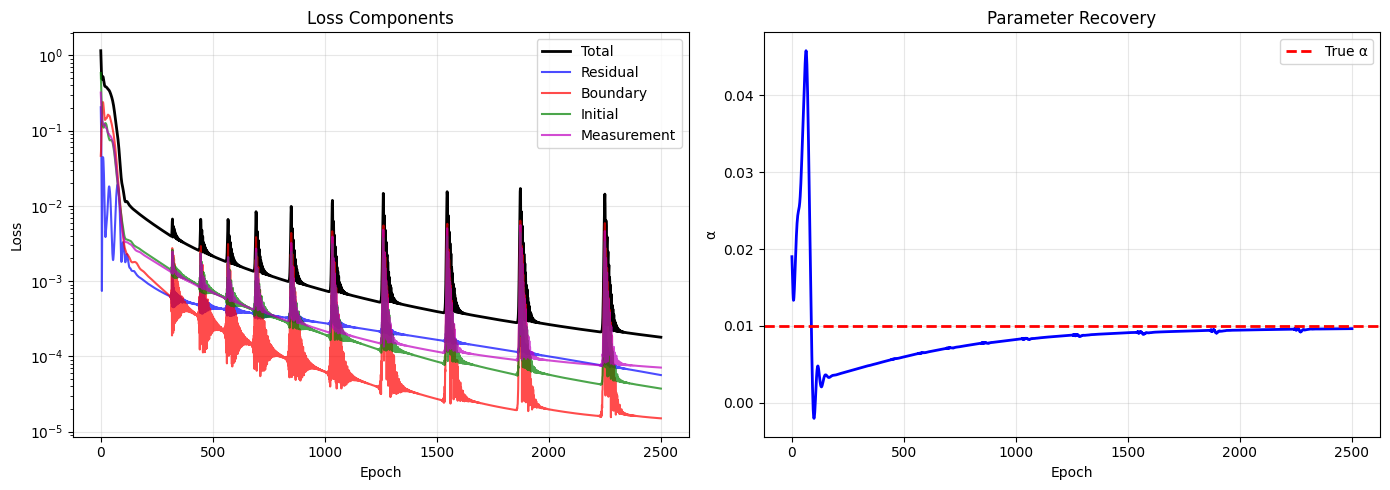


Epoch 3000/5000 (184.4s)
  Total Loss: 1.500095e-04
  Residual: 3.203853e-05 (λ=1.00)
  Boundary: 1.345519e-05 (λ=1.00)
  Initial: 3.287156e-05 (λ=1.00)
  Measurement: 7.164419e-05 (λ=1.00)
  Alpha: 0.009710 (true: 0.01)

Epoch 4000/5000 (246.1s)
  Total Loss: 6.091021e-04
  Residual: 3.056056e-05 (λ=1.00)
  Boundary: 2.134888e-04 (λ=1.00)
  Initial: 1.559497e-04 (λ=1.00)
  Measurement: 2.091030e-04 (λ=1.00)
  Alpha: 0.009966 (true: 0.01)

Final training plot:


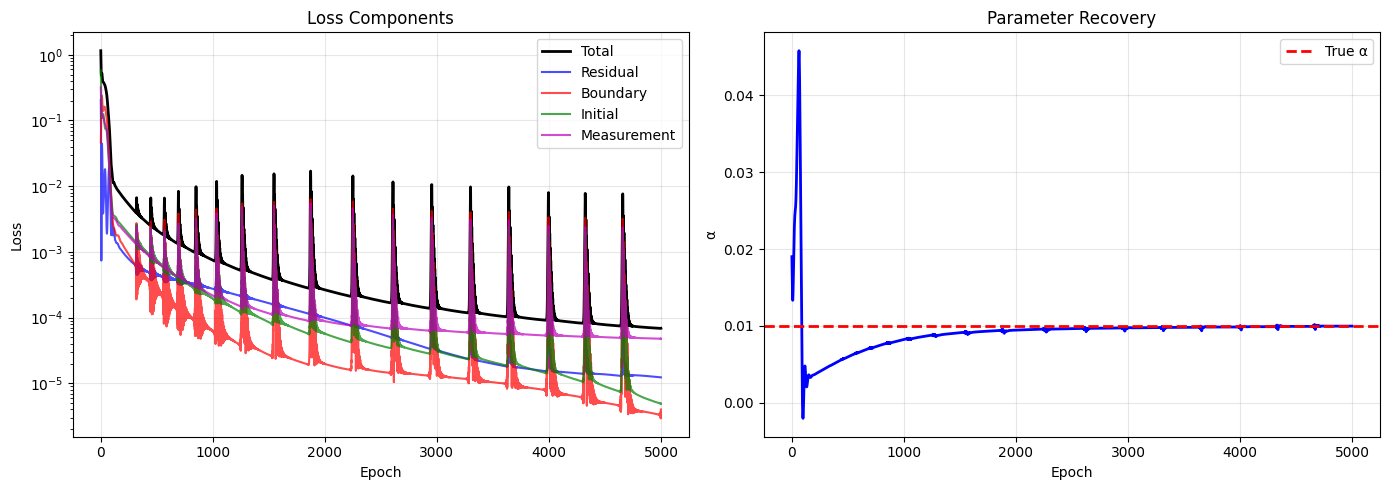


Training complete. Total time: 314.1s


In [ ]:
trainer_inverse = PINNTrainer(
    model=model_inverse,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_threshold=1e-12,
    track_gradient_norms=False,
    adaptive_weights=False,
)

trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate performance

In [22]:
alpha_true = 0.01
alpha_pred = model_inverse.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.009959
Error:         0.41%
SUCCESS: Parameter recovered within 5% error!


Visualize

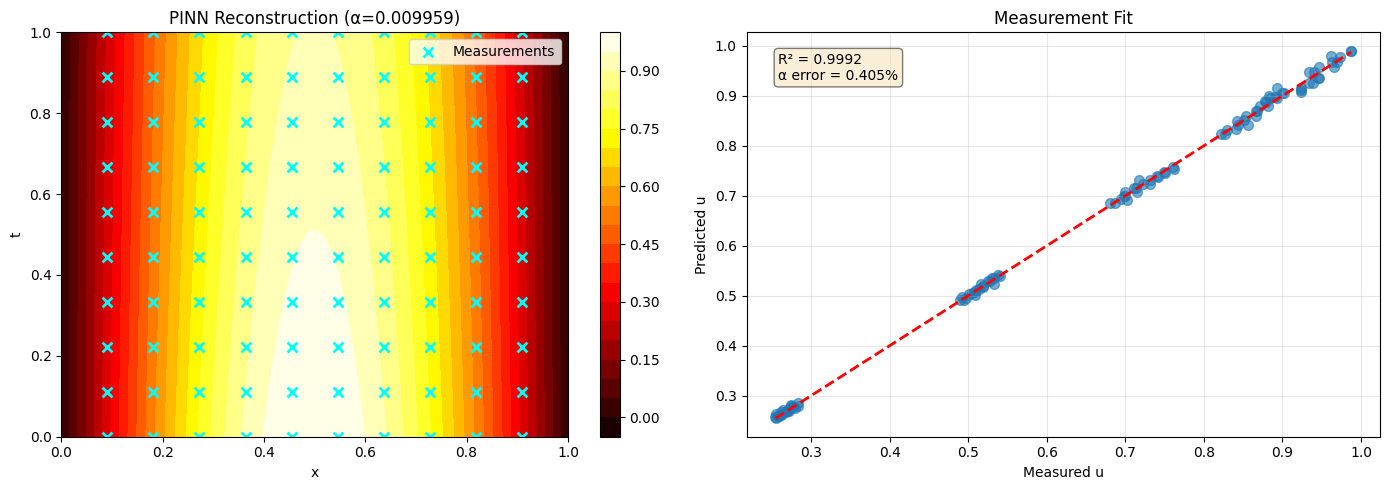

In [23]:
x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

x_flat = X.flatten().reshape(-1, 1)
t_flat = T.flatten().reshape(-1, 1)

u_pred_inv = model_inverse.predict(x_flat, t_flat).reshape(100, 100)

x_m = data['x_m'].cpu().numpy()
t_m = data['t_m'].cpu().numpy()
u_m = data['u_m'].cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Reconstructed solution with measurements
im1 = axes[0].contourf(X.numpy(), T.numpy(), u_pred_inv, levels=20, cmap='hot')
axes[0].scatter(x_m, t_m, c='cyan', s=50, marker='x', linewidths=2, label='Measurements')
axes[0].set_title(f'PINN Reconstruction (α={alpha_pred:.6f})')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].legend()
plt.colorbar(im1, ax=axes[0])

# Plot 2: Measurement fit
u_m_pred = model_inverse.predict(data['x_m'], data['t_m'])
axes[1].scatter(u_m, u_m_pred, alpha=0.6, s=50)
axes[1].plot([u_m.min(), u_m.max()], [u_m.min(), u_m.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Measured u')
axes[1].set_ylabel('Predicted u')
axes[1].set_title('Measurement Fit')
axes[1].grid(True, alpha=0.3)

r2 = 1 - np.sum((u_m - u_m_pred)**2) / np.sum((u_m - u_m.mean())**2)
axes[1].text(0.05, 0.95, f'R² = {r2:.4f}\nα error = {error_pct:.3f}%', 
            transform=axes[1].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### Fixed weights with L-BFGS

In [24]:
model_inverse = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02  # Initial guess
)

print(f"Initial alpha guess: {model_inverse.get_alpha():.6f}")
print(f"True alpha: 0.01")

Inverse problem mode: alpha initialized to 0.02
Initial alpha guess: 0.020000
True alpha: 0.01


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: False
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.221868e+00
  Residual: 8.087906e-03 (λ=1.00)
  Boundary: 9.856462e-03 (λ=1.00)
  Initial: 6.387463e-01 (λ=1.00)
  Measurement: 5.651771e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Switching to L-BFGS at epoch 904

Final training plot:


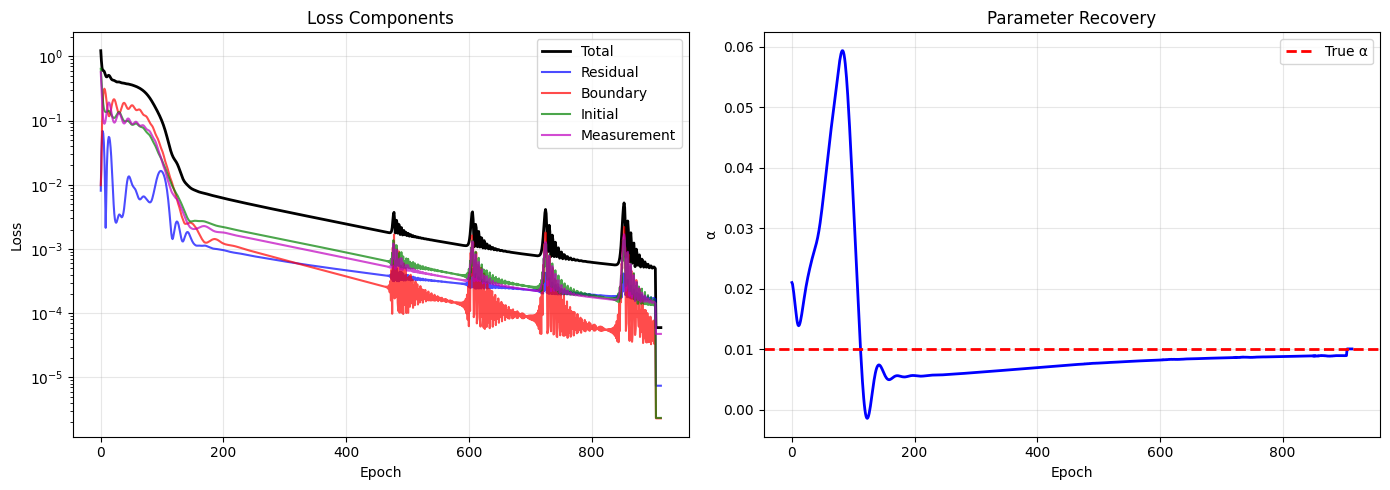


Training complete. Total time: 57.2s


In [25]:
trainer_inverse = PINNTrainer(
    model=model_inverse,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_threshold=5e-4,
    adaptive_weights=False,
)

trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate inverse problem

In [26]:
alpha_true = 0.01
alpha_pred = model_inverse.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.010036
Error:         0.36%
SUCCESS: Parameter recovered within 5% error!


Visualize inverse problem results

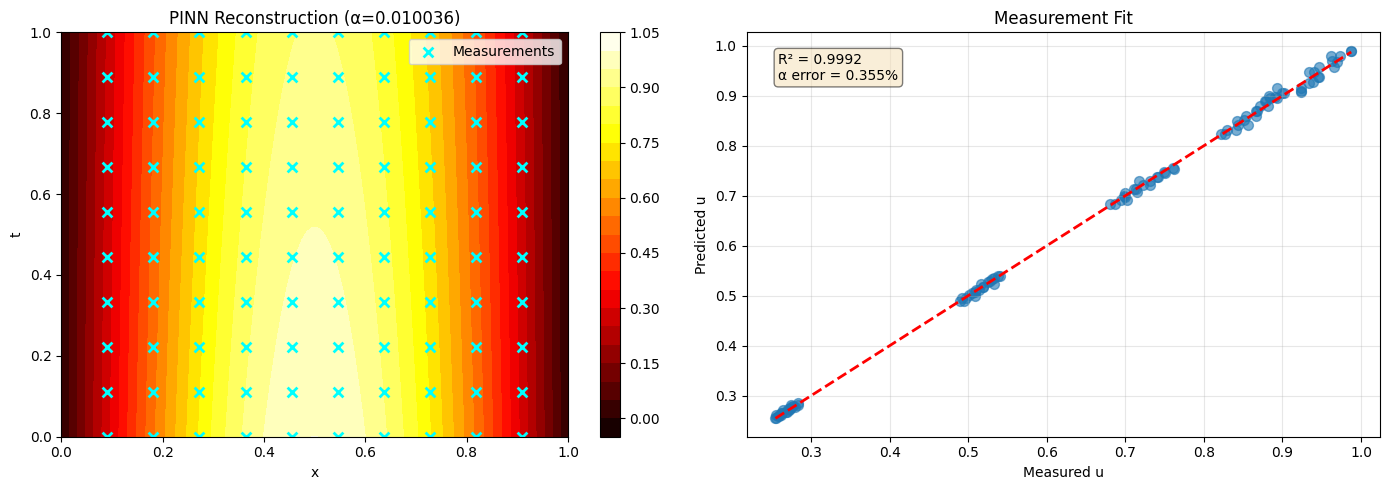

In [27]:
x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

x_flat = X.flatten().reshape(-1, 1)
t_flat = T.flatten().reshape(-1, 1)

u_pred_inv = model_inverse.predict(x_flat, t_flat).reshape(100, 100)

x_m = data['x_m'].cpu().numpy()
t_m = data['t_m'].cpu().numpy()
u_m = data['u_m'].cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Reconstructed solution with measurements
im1 = axes[0].contourf(X.numpy(), T.numpy(), u_pred_inv, levels=20, cmap='hot')
axes[0].scatter(x_m, t_m, c='cyan', s=50, marker='x', linewidths=2, label='Measurements')
axes[0].set_title(f'PINN Reconstruction (α={alpha_pred:.6f})')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].legend()
plt.colorbar(im1, ax=axes[0])

# Plot 2: Measurement fit
u_m_pred = model_inverse.predict(data['x_m'], data['t_m'])
axes[1].scatter(u_m, u_m_pred, alpha=0.6, s=50)
axes[1].plot([u_m.min(), u_m.max()], [u_m.min(), u_m.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Measured u')
axes[1].set_ylabel('Predicted u')
axes[1].set_title('Measurement Fit')
axes[1].grid(True, alpha=0.3)

r2 = 1 - np.sum((u_m - u_m_pred)**2) / np.sum((u_m - u_m.mean())**2)
axes[1].text(0.05, 0.95, f'R² = {r2:.4f}\nα error = {error_pct:.3f}%', 
            transform=axes[1].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### Adaptive weight with L-BFGS

In [28]:
model_inverse = HeatPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02  # Initial guess
)

print(f"Initial alpha guess: {model_inverse.get_alpha():.6f}")
print(f"True alpha: 0.01")

Inverse problem mode: alpha initialized to 0.02
Initial alpha guess: 0.020000
True alpha: 0.01


Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 9.791916e-01
  Residual: 2.453716e-02 (λ=1.00)
  Boundary: 6.809929e-03 (λ=1.00)
  Initial: 4.281229e-01 (λ=1.00)
  Measurement: 5.197216e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Epoch 1000/5000 (61.2s)
  Total Loss: 8.394094e-04
  Residual: 5.058895e-05 (λ=6.96)
  Boundary: 1.657315e-04 (λ=0.52)
  Initial: 1.493124e-04 (λ=1.50)
  Measurement: 2.223920e-04 (λ=0.80)
  Alpha: 0.007029 (true: 0.01)

Switching to L-BFGS at epoch 1220

Final training plot:


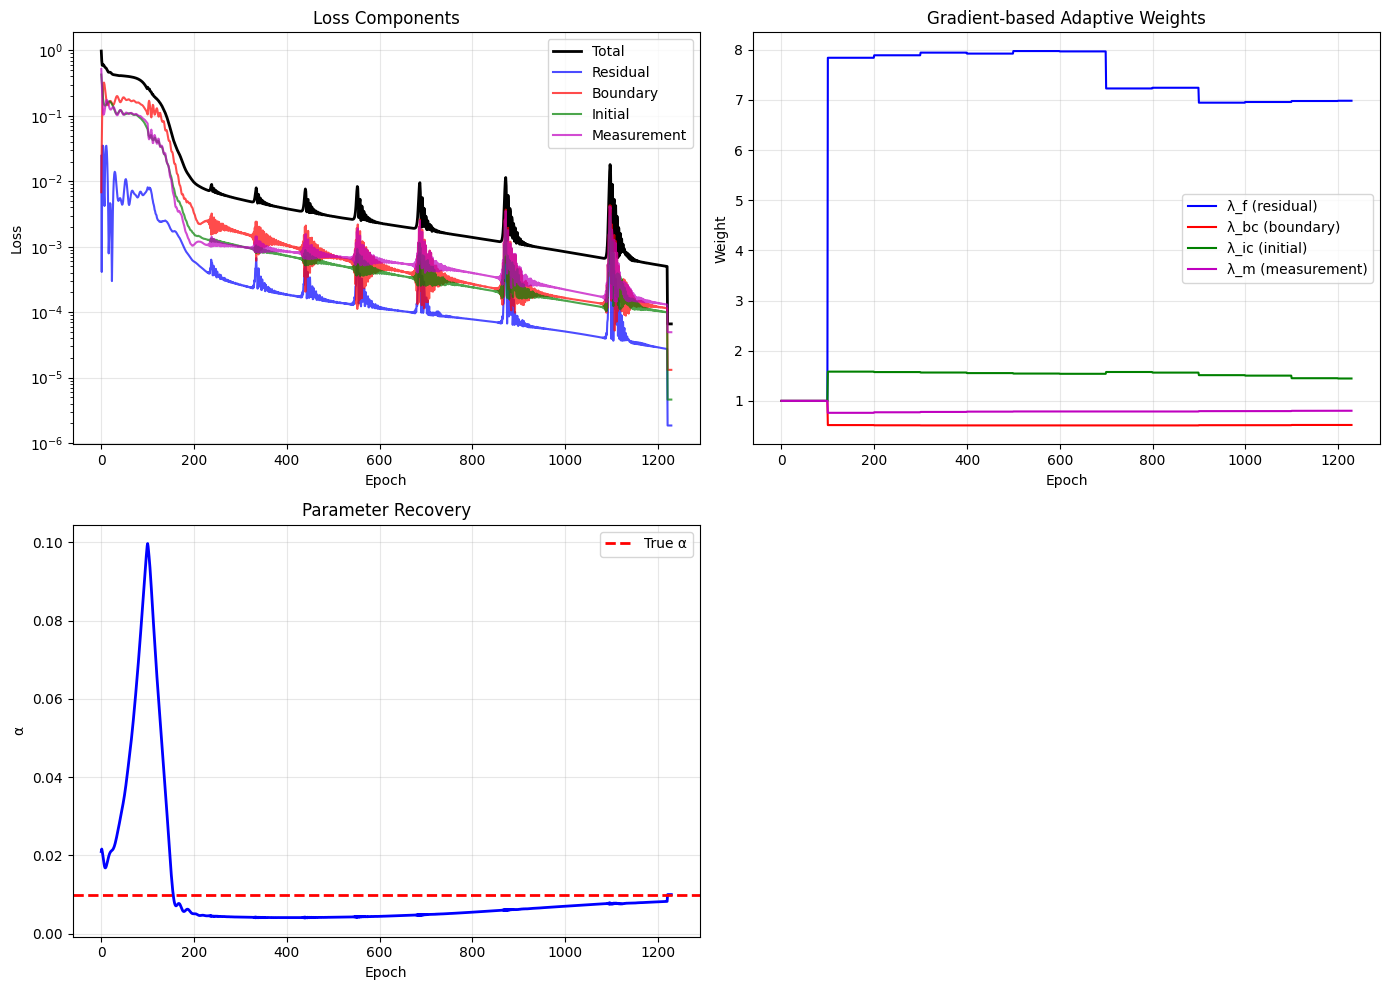


Training complete. Total time: 83.0s


In [29]:
trainer_inverse = PINNTrainer(
    model=model_inverse,
    data=data,
    device='cpu',
    learning_rate=1e-3,
    switch_threshold=5e-4,
    track_gradient_norms=False,
    adaptive_weights=True,
)

# Inverse problems typically need more epochs
trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

Evaluate

In [30]:
alpha_true = 0.01
alpha_pred = model_inverse.get_alpha()
error_pct = abs(alpha_pred - alpha_true) / alpha_true * 100

print("\n" + "=" * 50)
print("INVERSE PROBLEM RESULTS")
print("=" * 50)
print(f"True α:        {alpha_true:.6f}")
print(f"Predicted α:   {alpha_pred:.6f}")
print(f"Error:         {error_pct:.2f}%")
print("=" * 50)

if error_pct < 5:
    print("SUCCESS: Parameter recovered within 5% error!")
else:
    print("Try training longer or adjusting hyperparameters")


INVERSE PROBLEM RESULTS
True α:        0.010000
Predicted α:   0.010005
Error:         0.05%
SUCCESS: Parameter recovered within 5% error!


Visualize

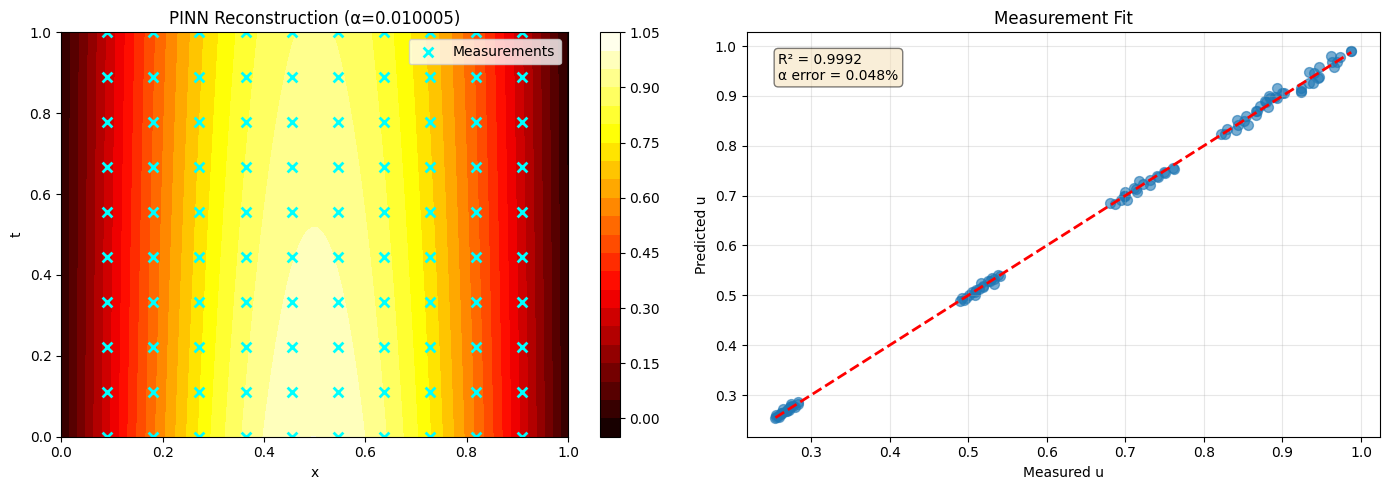

In [31]:
x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

x_flat = X.flatten().reshape(-1, 1)
t_flat = T.flatten().reshape(-1, 1)

u_pred_inv = model_inverse.predict(x_flat, t_flat).reshape(100, 100)

x_m = data['x_m'].cpu().numpy()
t_m = data['t_m'].cpu().numpy()
u_m = data['u_m'].cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Reconstructed solution with measurements
im1 = axes[0].contourf(X.numpy(), T.numpy(), u_pred_inv, levels=20, cmap='hot')
axes[0].scatter(x_m, t_m, c='cyan', s=50, marker='x', linewidths=2, label='Measurements')
axes[0].set_title(f'PINN Reconstruction (α={alpha_pred:.6f})')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].legend()
plt.colorbar(im1, ax=axes[0])

# Plot 2: Measurement fit
u_m_pred = model_inverse.predict(data['x_m'], data['t_m'])
axes[1].scatter(u_m, u_m_pred, alpha=0.6, s=50)
axes[1].plot([u_m.min(), u_m.max()], [u_m.min(), u_m.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Measured u')
axes[1].set_ylabel('Predicted u')
axes[1].set_title('Measurement Fit')
axes[1].grid(True, alpha=0.3)

r2 = 1 - np.sum((u_m - u_m_pred)**2) / np.sum((u_m - u_m.mean())**2)
axes[1].text(0.05, 0.95, f'R² = {r2:.4f}\nα error = {error_pct:.3f}%', 
            transform=axes[1].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

**Conclusion**: the adaptive weights helped for the inverse problem!

## Step 4: Experiment with Various Settings

### Effect of noise level


Noise level: 0.1%
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 0.1% (SNR ≈ 60 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 60.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.0s)

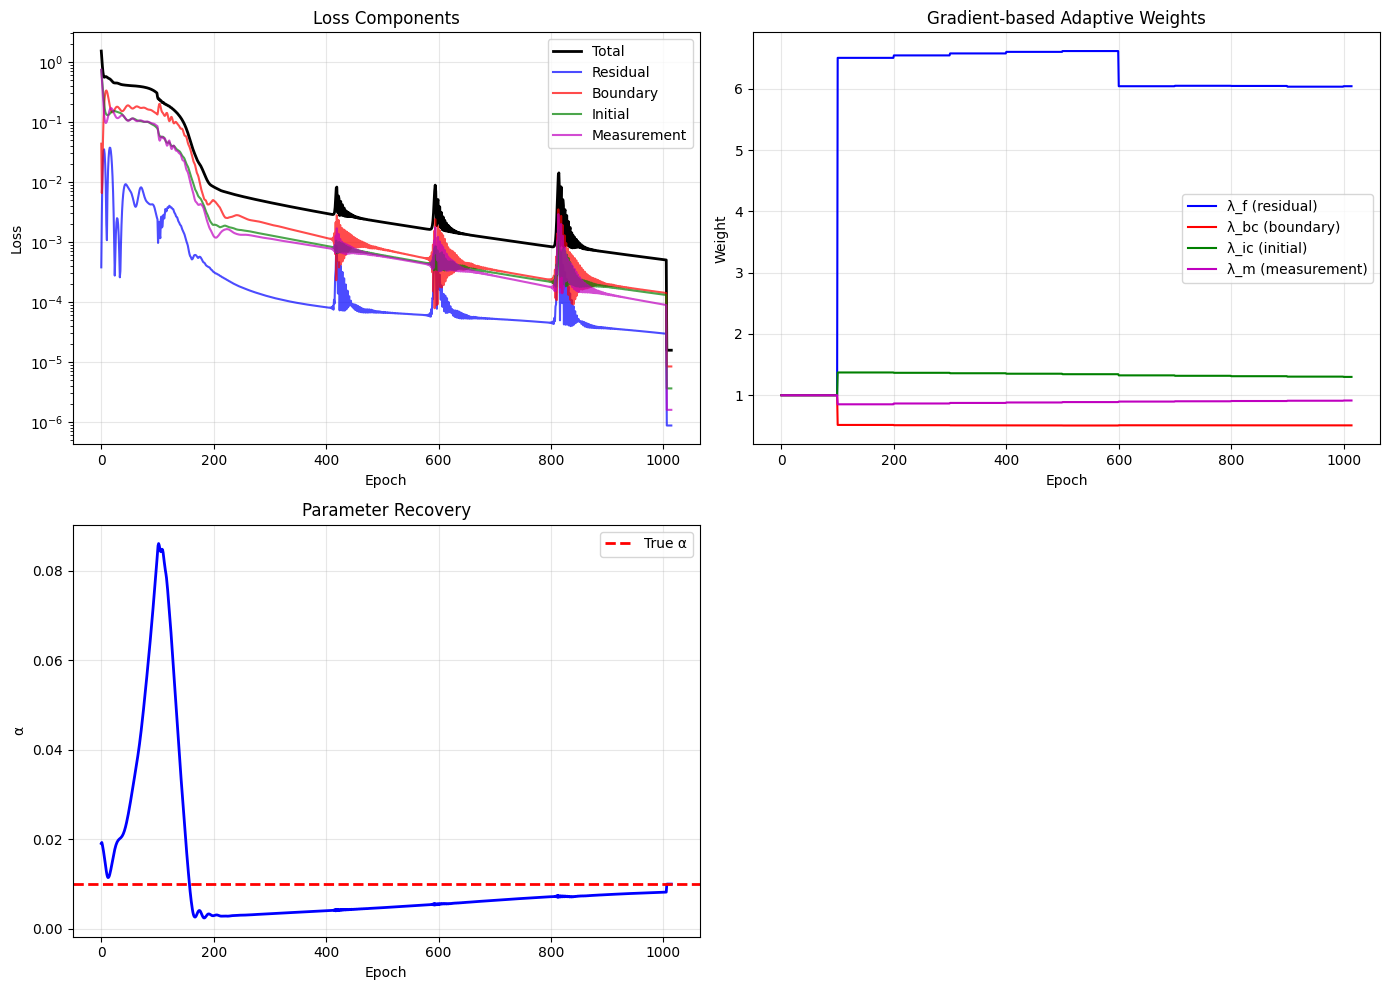


Training complete. Total time: 61.9s

Noise level: 1.0%
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 40.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Sta

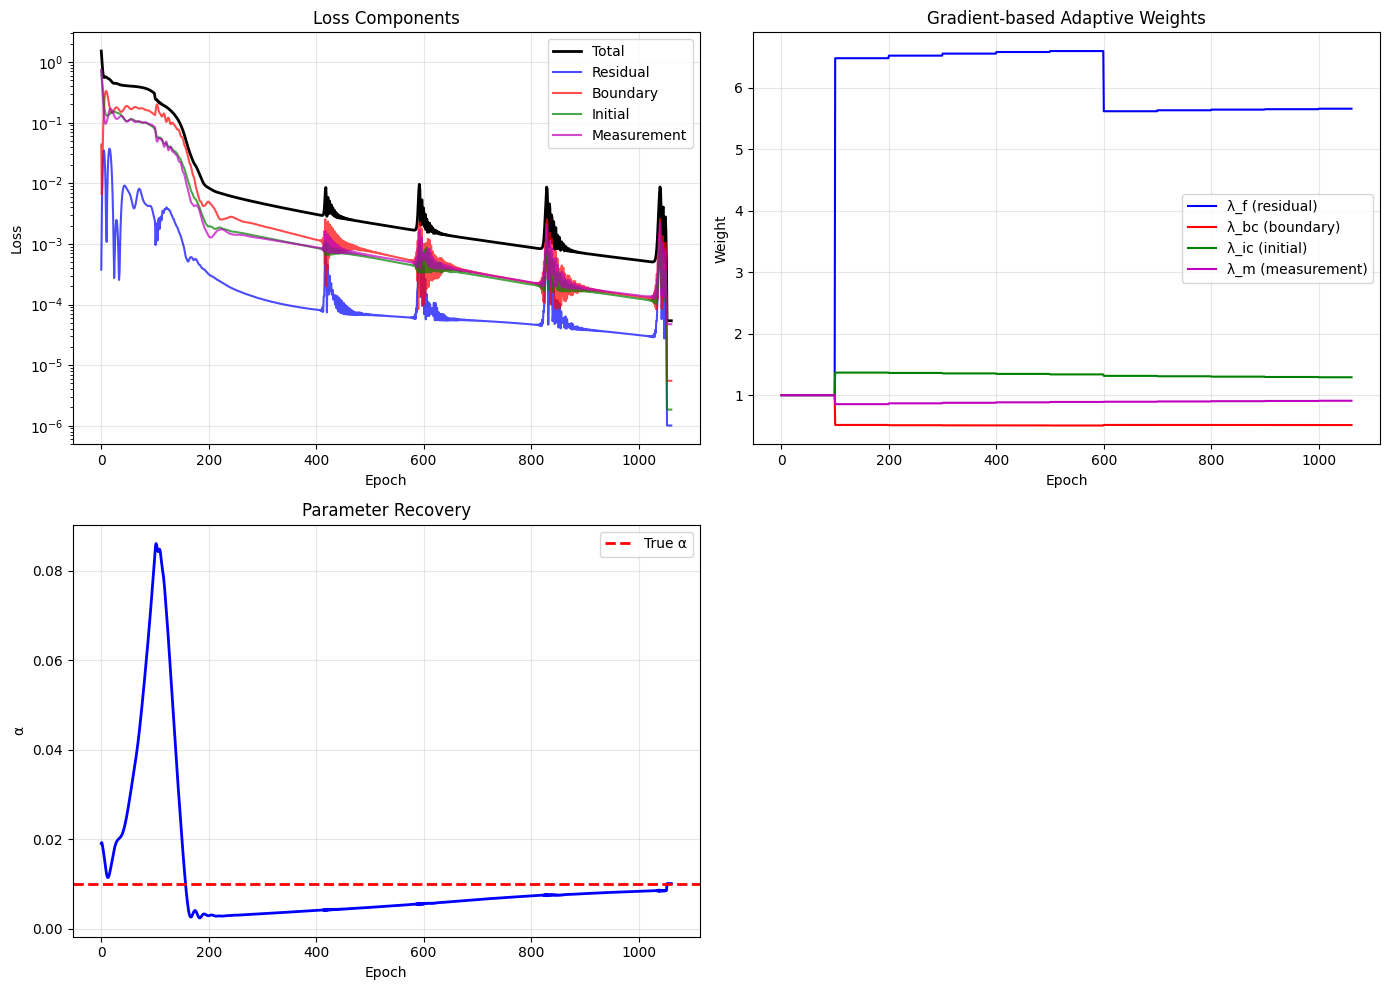


Training complete. Total time: 69.0s

Noise level: 5.0%
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 5.0% (SNR ≈ 26 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 26.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Sta

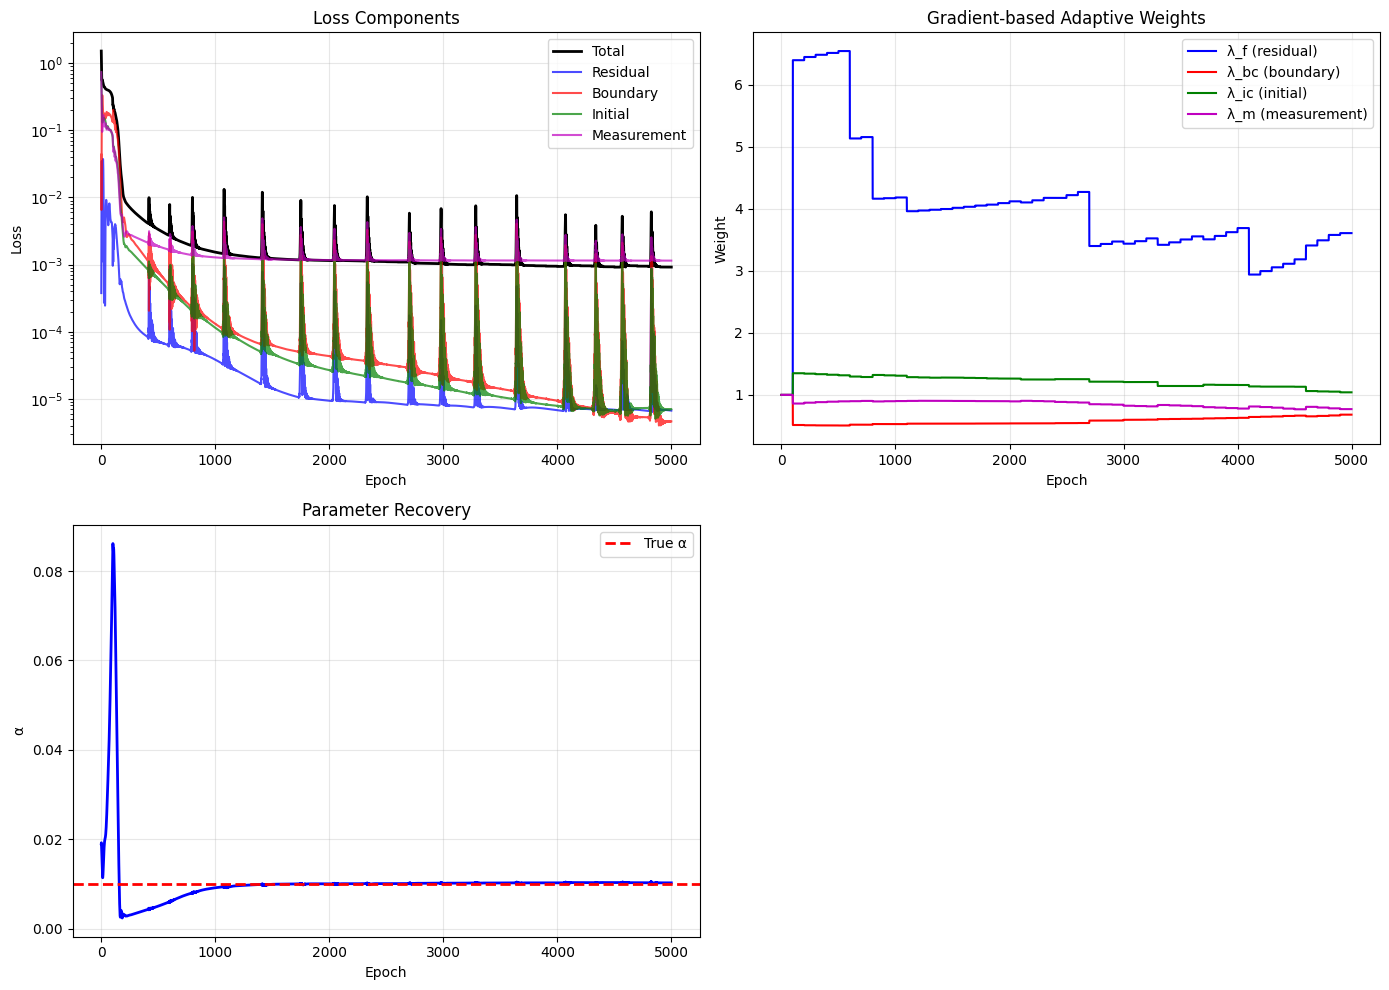


Training complete. Total time: 286.2s

Noise level: 10.0%
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 10.0% (SNR ≈ 20 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 20.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse



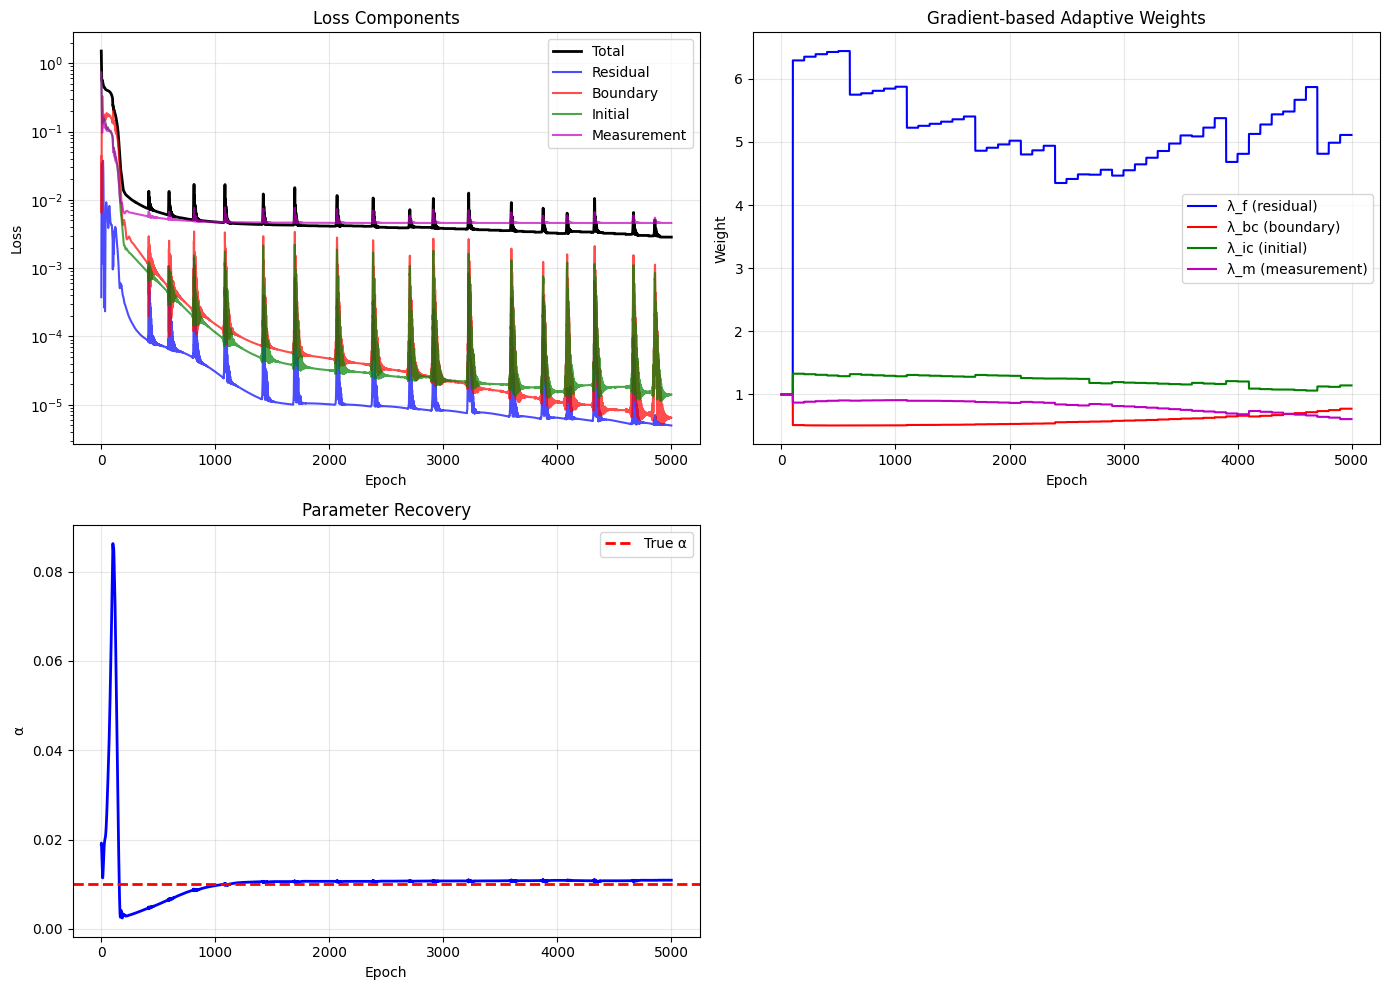


Training complete. Total time: 278.1s


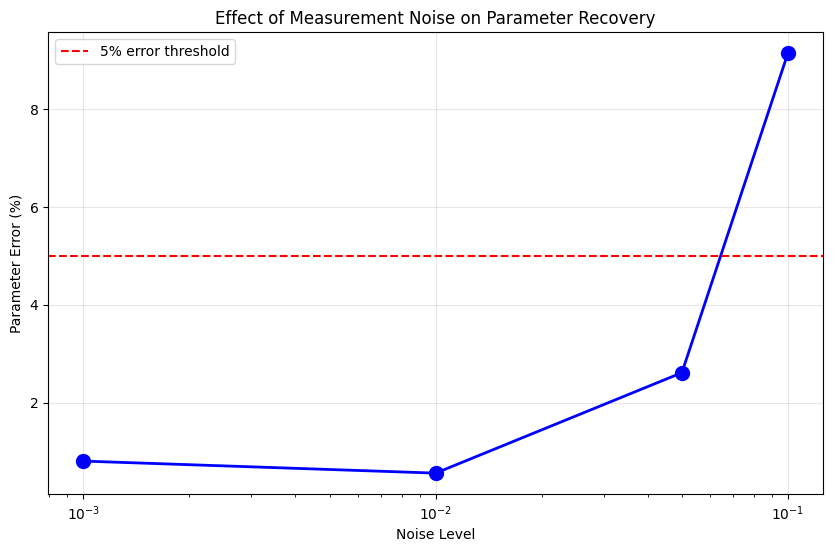

In [32]:
noise_levels = [0.001, 0.01, 0.05, 0.1]  # 0.1%, 1%, 5%, 10%
results = []

for noise in noise_levels:
    print(f"\nNoise level: {noise:.1%}")
    
    # Generate new data with different noise levels
    data_gen_temp = HeatEquationData(
        N_f=10000, 
        N_bc=100,
        N_ic=200,
        N_sensors=10, 
        N_time_measurements=10,
        noise_level=noise, 
        device='cpu'
    )
    data_temp = data_gen_temp.generate_full_dataset()
    
    # Train inverse model for 5000 epochs
    model_temp = HeatPINN(inverse=True, alpha_init=0.02)
    trainer_temp = PINNTrainer(model_temp, data_temp, learning_rate=1e-3, switch_threshold=5e-4, adaptive_weights=True)
    trainer_temp.train(epochs=5000, print_every=2500, plot_every=5000)
    
    # Record results
    alpha_recovered = model_temp.get_alpha()
    error = abs(alpha_recovered - 0.01) / 0.01 * 100
    results.append({
        'noise': noise,
        'alpha': alpha_recovered,
        'error': error
    })

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
noises = [r['noise'] for r in results]
errors = [r['error'] for r in results]

ax.plot(noises, errors, 'bo-', markersize=10, linewidth=2)
ax.axhline(y=5, color='r', linestyle='--', label='5% error threshold')
ax.set_xlabel('Noise Level')
ax.set_ylabel('Parameter Error (%)')
ax.set_title('Effect of Measurement Noise on Parameter Recovery')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

### Uncertainty Quantification

Use different RNG seeds to train models and study the variation in predicting $\alpha$

Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.986863e+00
  Residual: 5.275653e-03 (λ=1.00)
  Boundary: 1.129718e-01 (λ=1.00)
  Initial: 9.041088e-01 (λ=1.00)
  Measurement: 9.645065e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Switching to L-BFGS at epoch 1223

Final training plot:


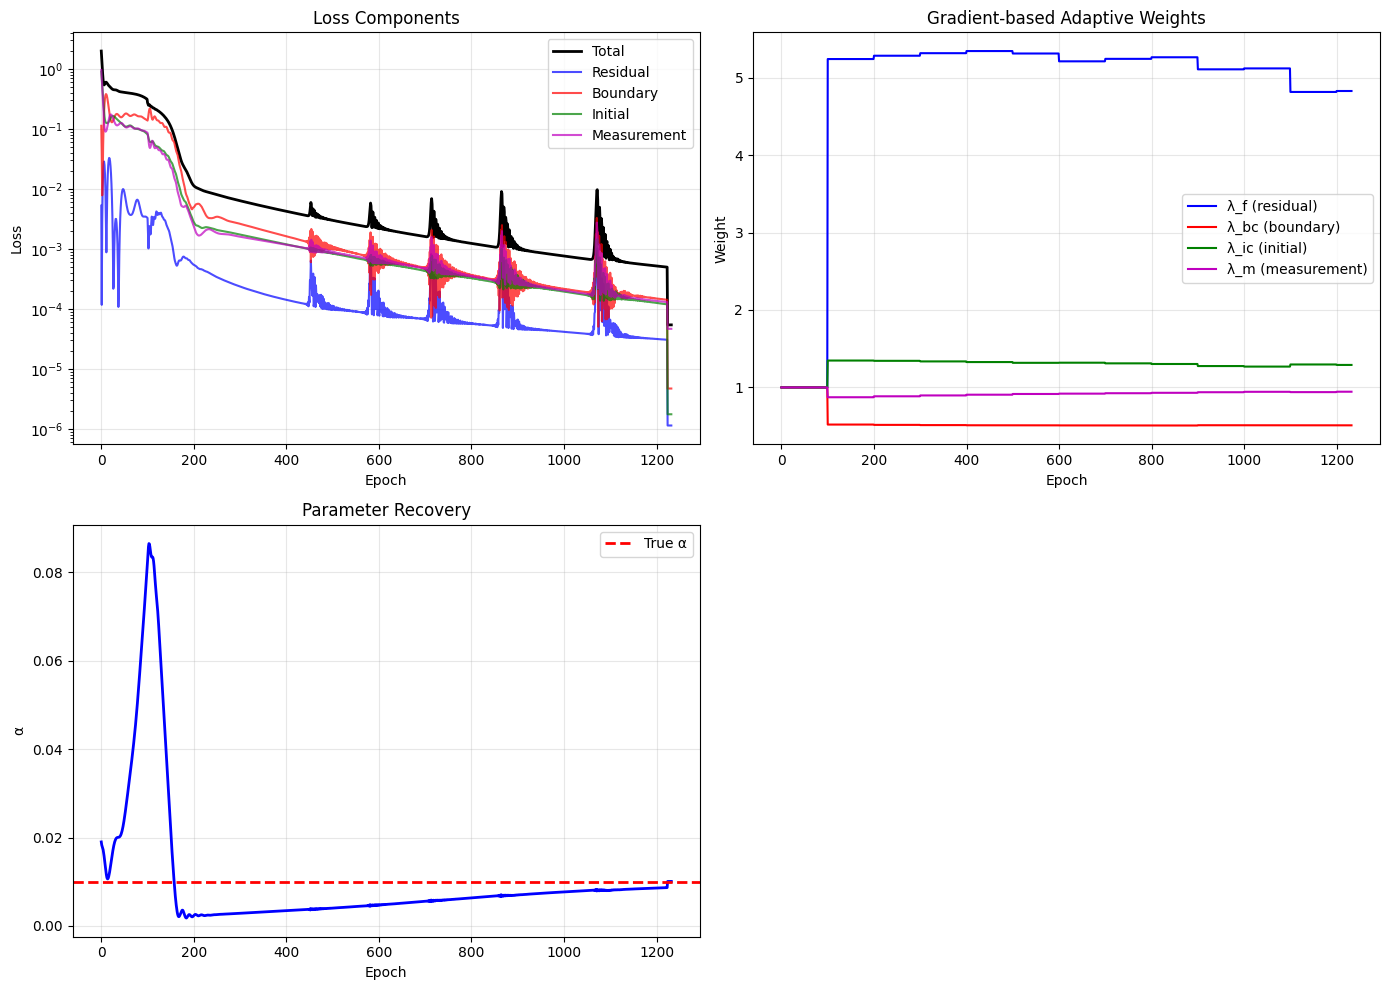


Training complete. Total time: 85.3s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.126033e+00
  Residual: 6.696954e-03 (λ=1.00)
  Boundary: 4.462265e-03 (λ=1.00)
  Initial: 5.330613e-01 (λ=1.00)
  Measurement: 5.818123e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Switching to L-BFGS at epoch 876

Final training plot:


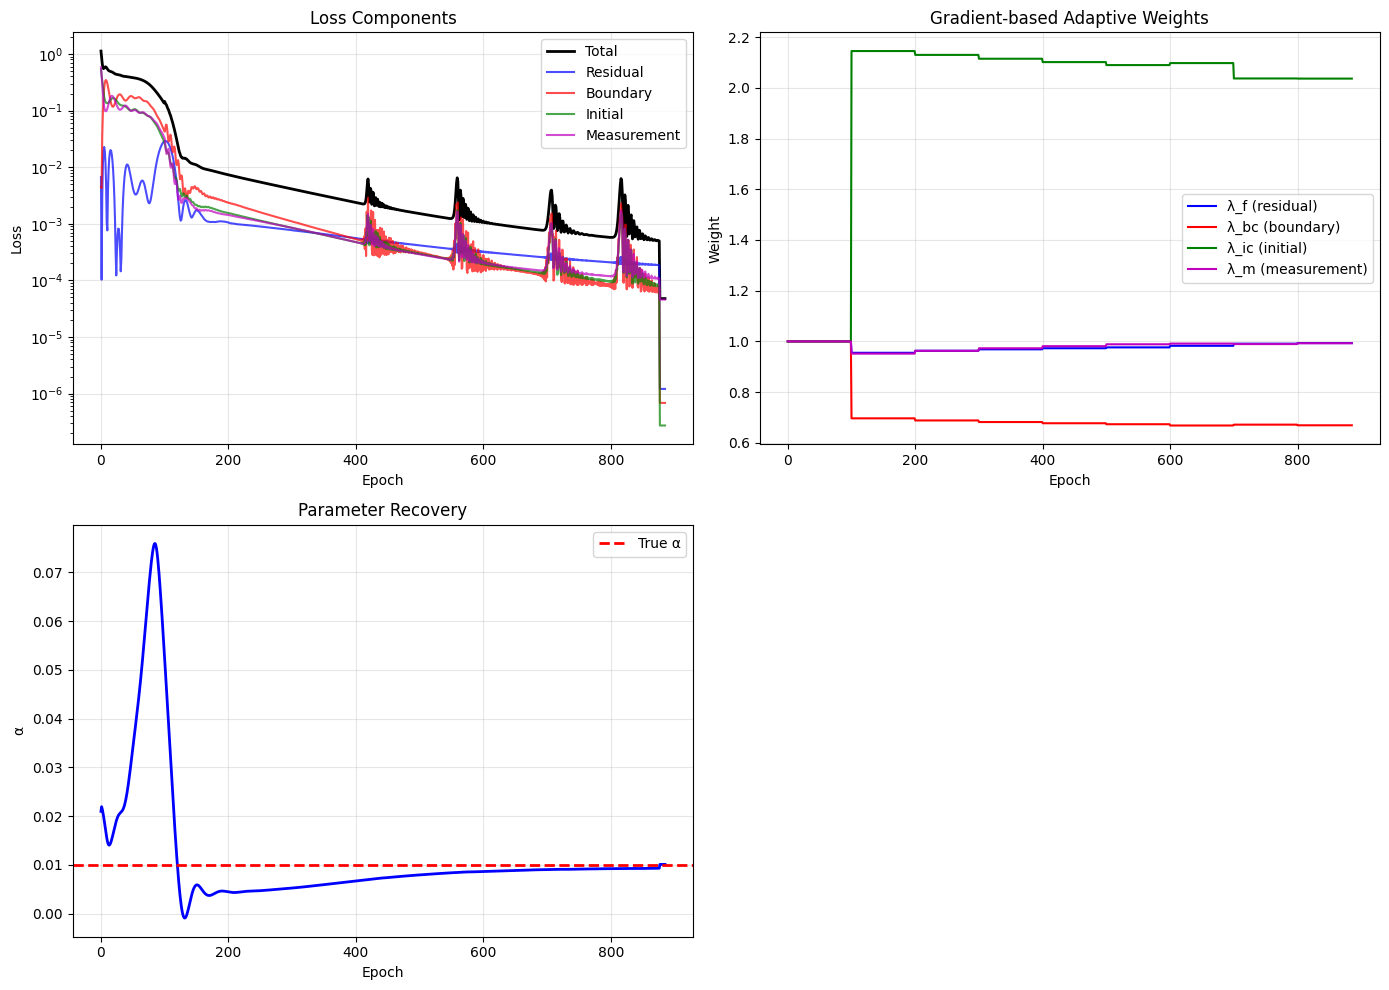


Training complete. Total time: 61.4s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.156174e+00
  Residual: 1.793606e-02 (λ=1.00)
  Boundary: 6.986184e-03 (λ=1.00)
  Initial: 5.212489e-01 (λ=1.00)
  Measurement: 6.100031e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Switching to L-BFGS at epoch 1299

Final training plot:


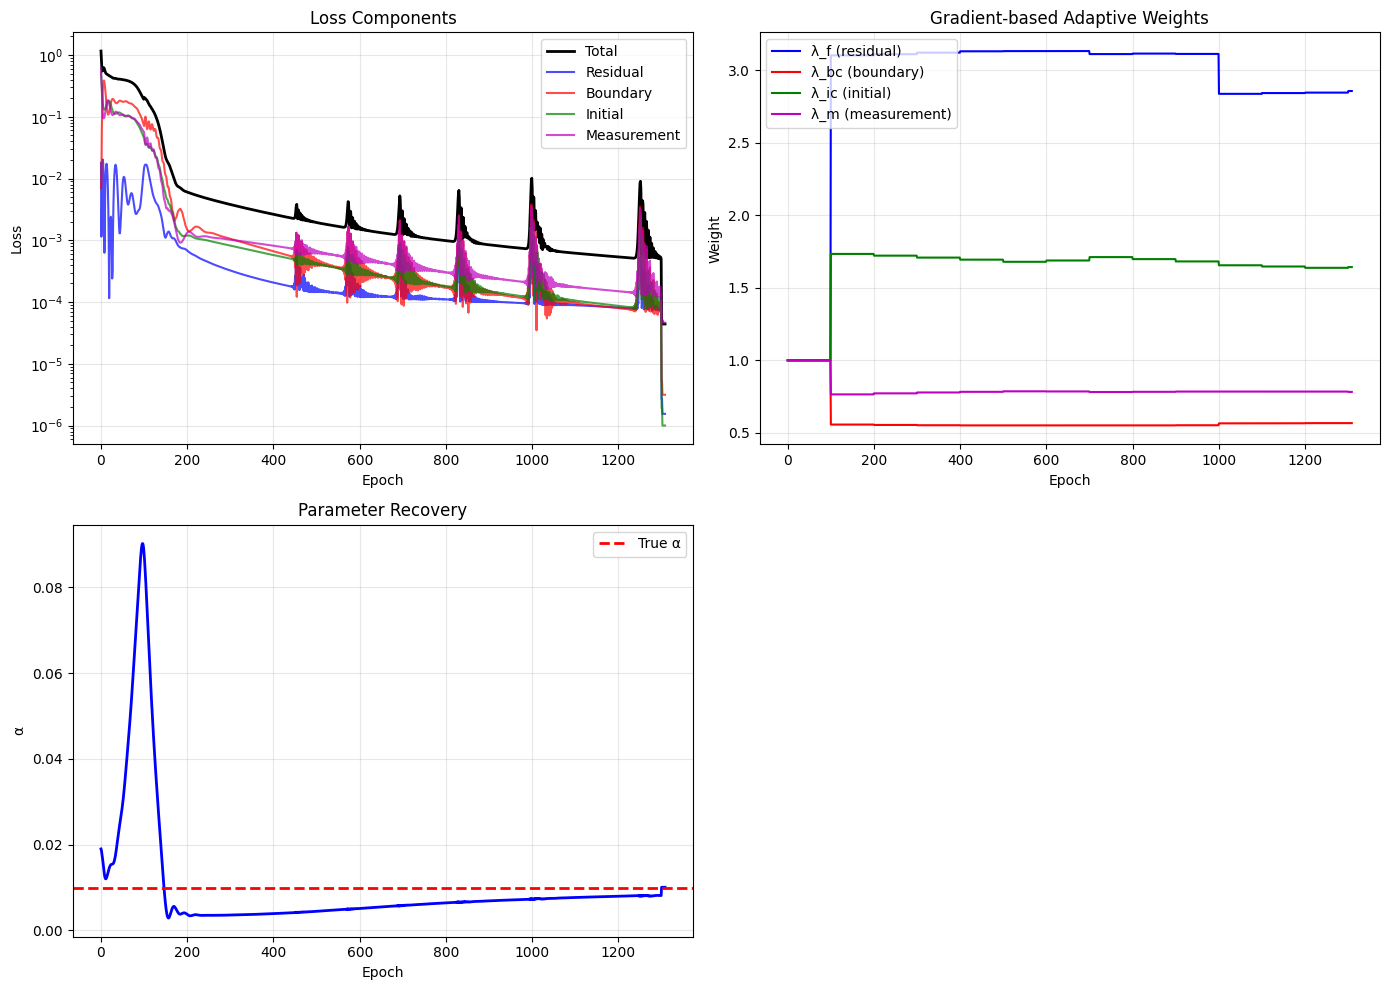


Training complete. Total time: 79.0s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.0s)
  Total Loss: 1.016659e+00
  Residual: 2.238766e-01 (λ=1.00)
  Boundary: 8.306137e-02 (λ=1.00)
  Initial: 4.720625e-01 (λ=1.00)
  Measurement: 2.376590e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Switching to L-BFGS at epoch 582

Final training plot:


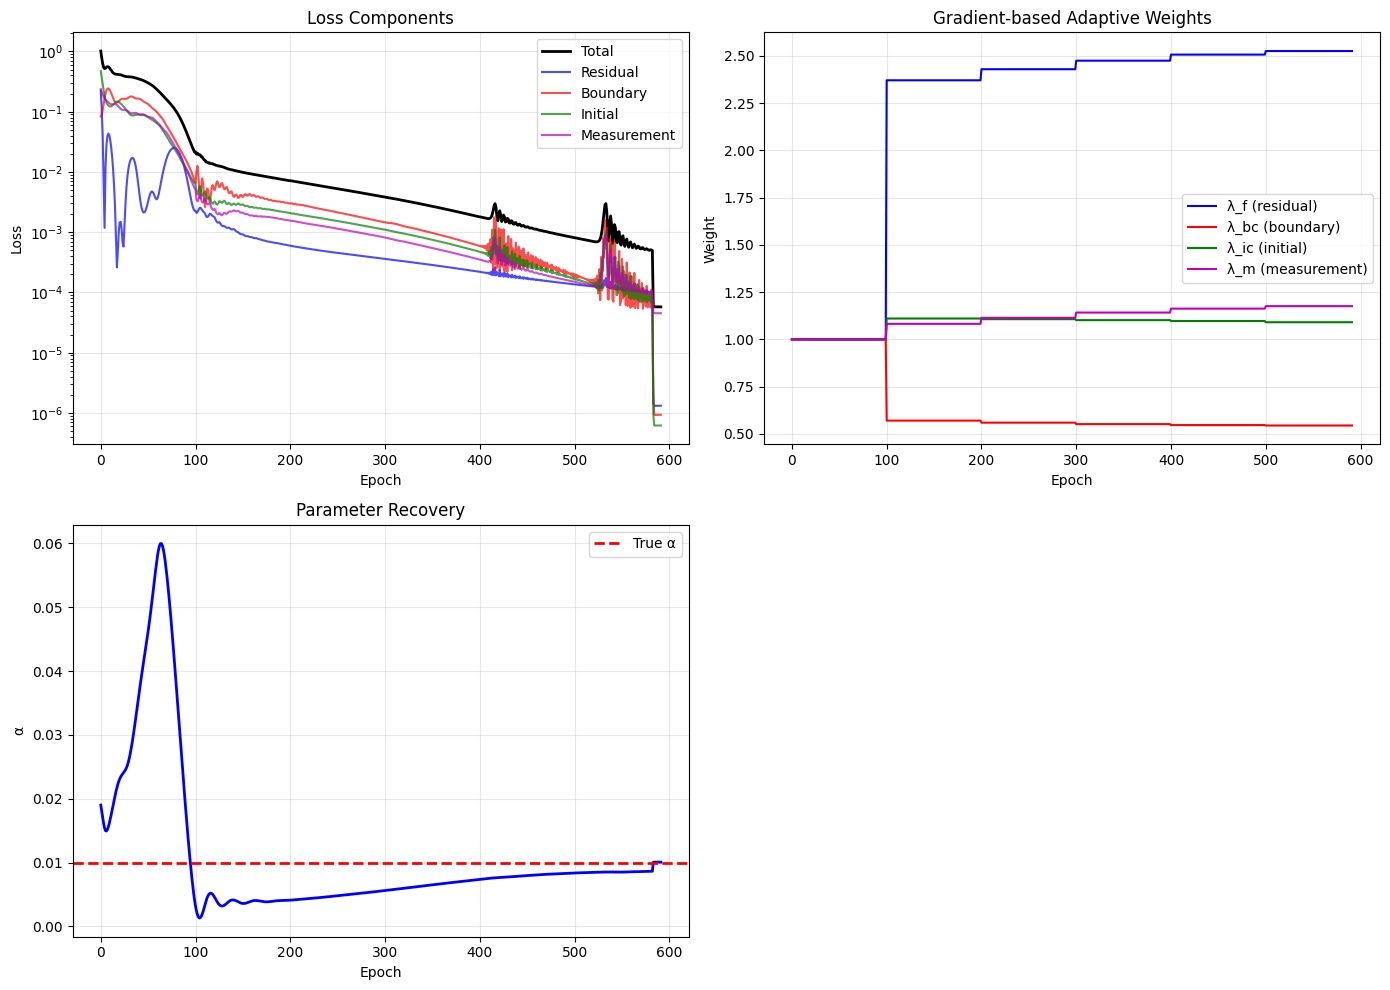


Training complete. Total time: 40.5s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.0s)
  Total Loss: 1.338553e+00
  Residual: 3.597515e-04 (λ=1.00)
  Boundary: 1.917126e-02 (λ=1.00)
  Initial: 6.651743e-01 (λ=1.00)
  Measurement: 6.538478e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Switching to L-BFGS at epoch 1316

Final training plot:


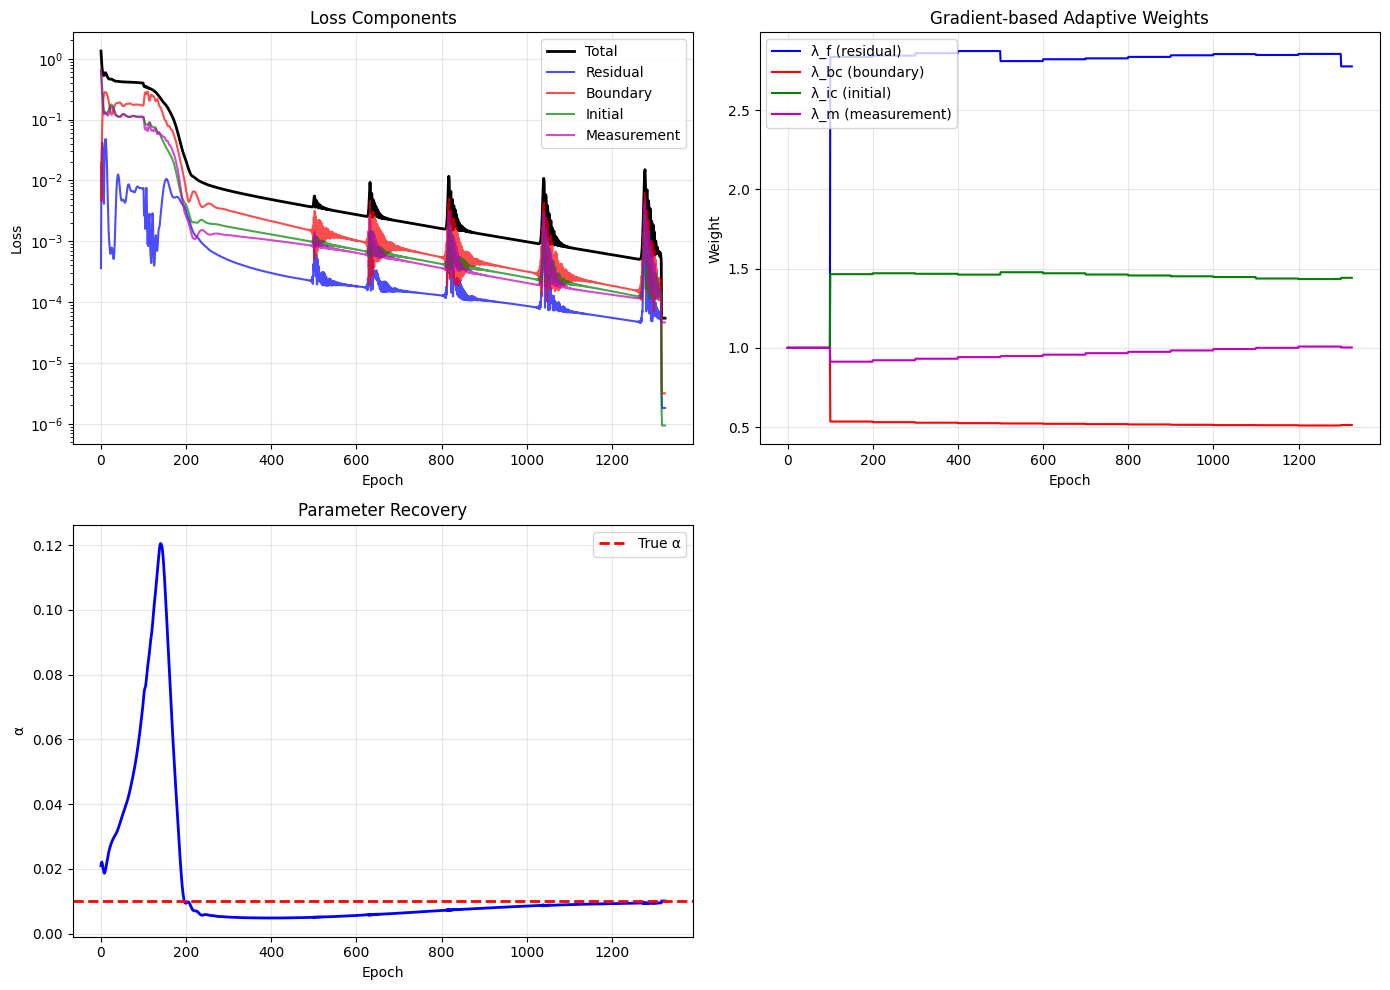


Training complete. Total time: 78.2s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.267476e+00
  Residual: 1.647010e-02 (λ=1.00)
  Boundary: 1.492682e-02 (λ=1.00)
  Initial: 5.742816e-01 (λ=1.00)
  Measurement: 6.617976e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Switching to L-BFGS at epoch 1367

Final training plot:


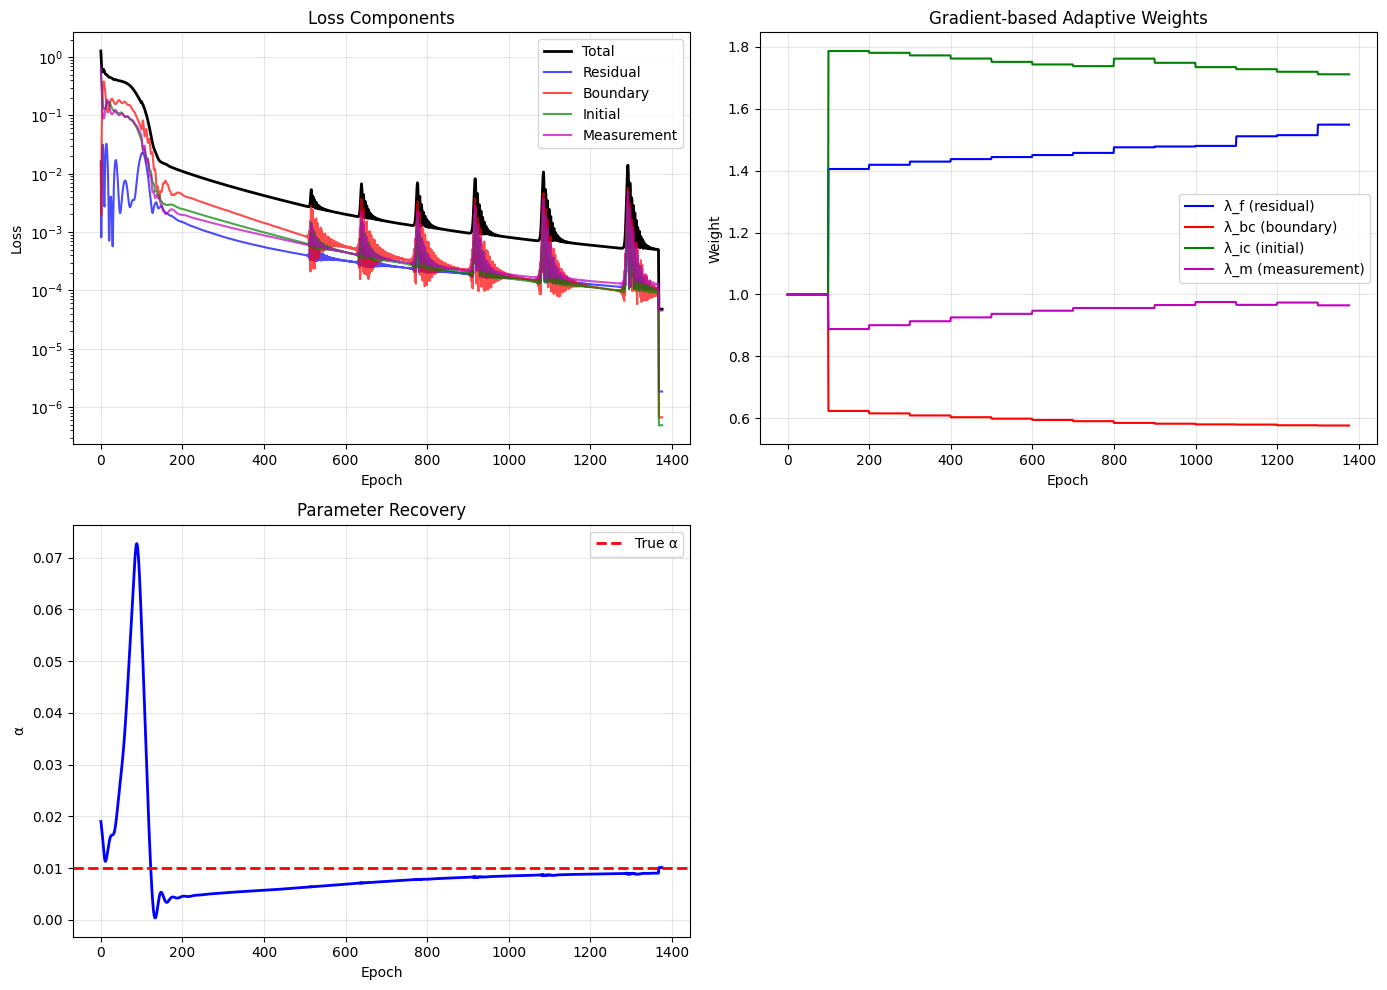


Training complete. Total time: 88.8s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 9.418670e-01
  Residual: 4.503932e-02 (λ=1.00)
  Boundary: 1.325617e-02 (λ=1.00)
  Initial: 5.097075e-01 (λ=1.00)
  Measurement: 3.738640e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Switching to L-BFGS at epoch 979

Final training plot:


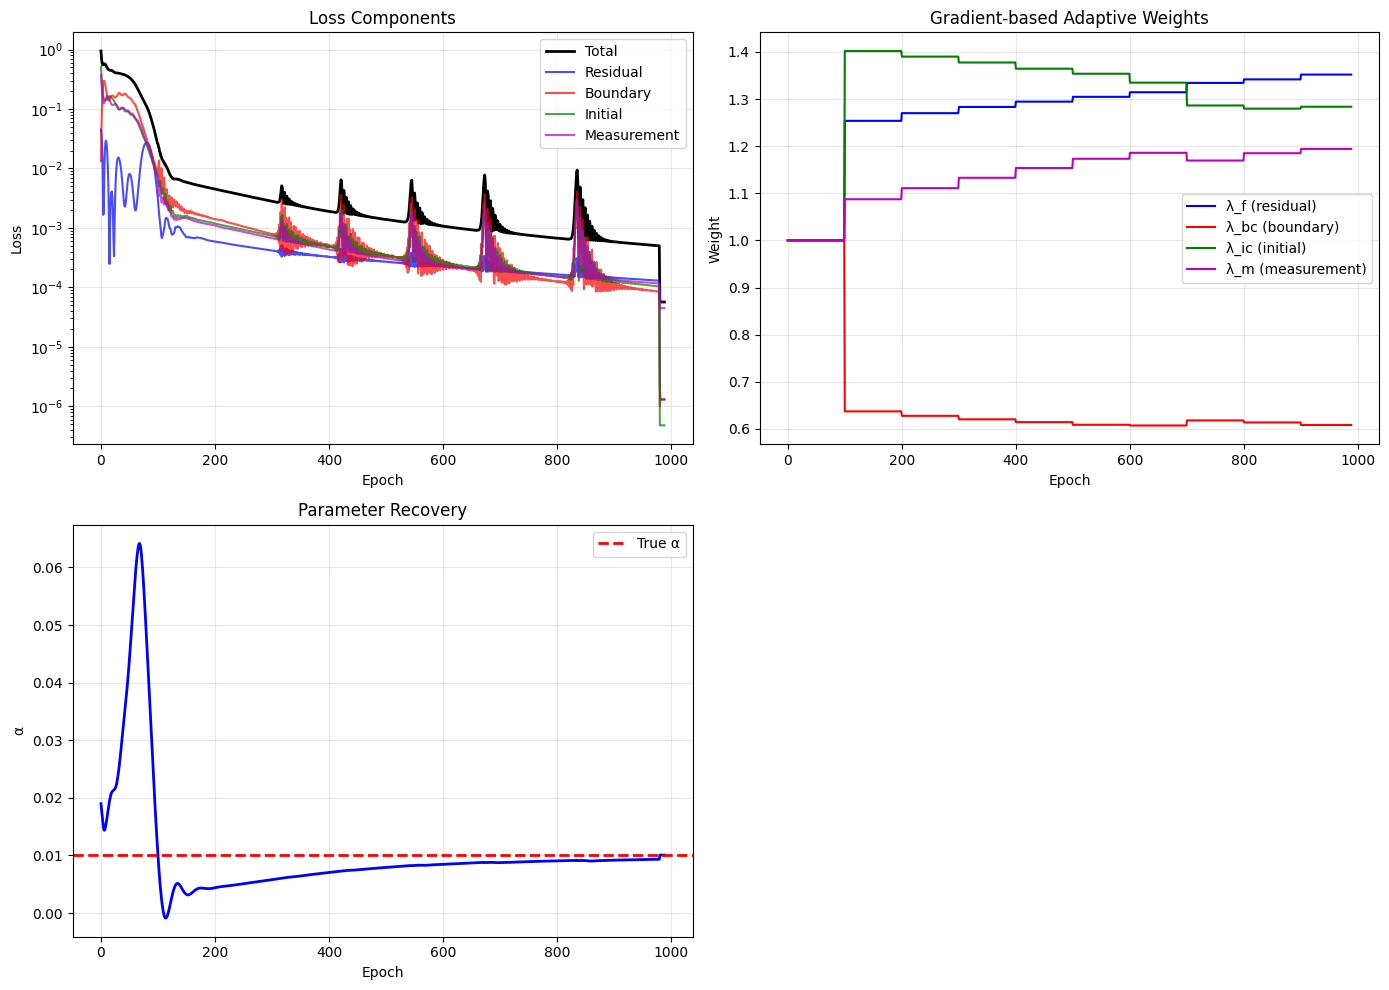


Training complete. Total time: 63.0s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.0s)
  Total Loss: 1.138059e+00
  Residual: 9.023647e-02 (λ=1.00)
  Boundary: 1.778947e-02 (λ=1.00)
  Initial: 4.168714e-01 (λ=1.00)
  Measurement: 6.131615e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Switching to L-BFGS at epoch 957

Final training plot:


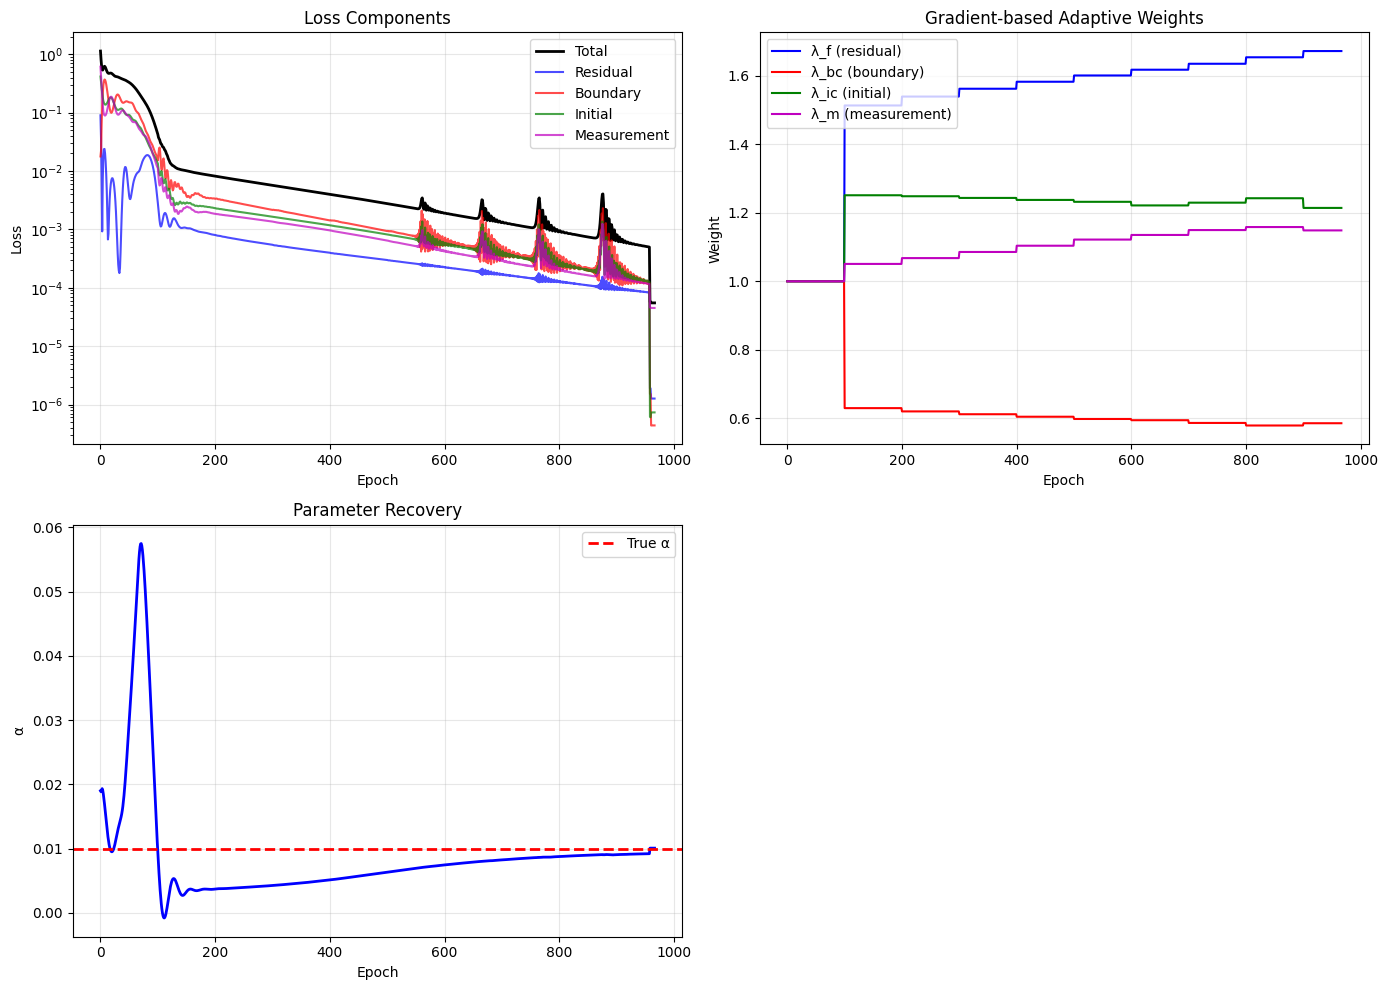


Training complete. Total time: 61.6s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.272557e+00
  Residual: 6.419275e-02 (λ=1.00)
  Boundary: 1.907125e-02 (λ=1.00)
  Initial: 6.893194e-01 (λ=1.00)
  Measurement: 4.999742e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Switching to L-BFGS at epoch 1110

Final training plot:


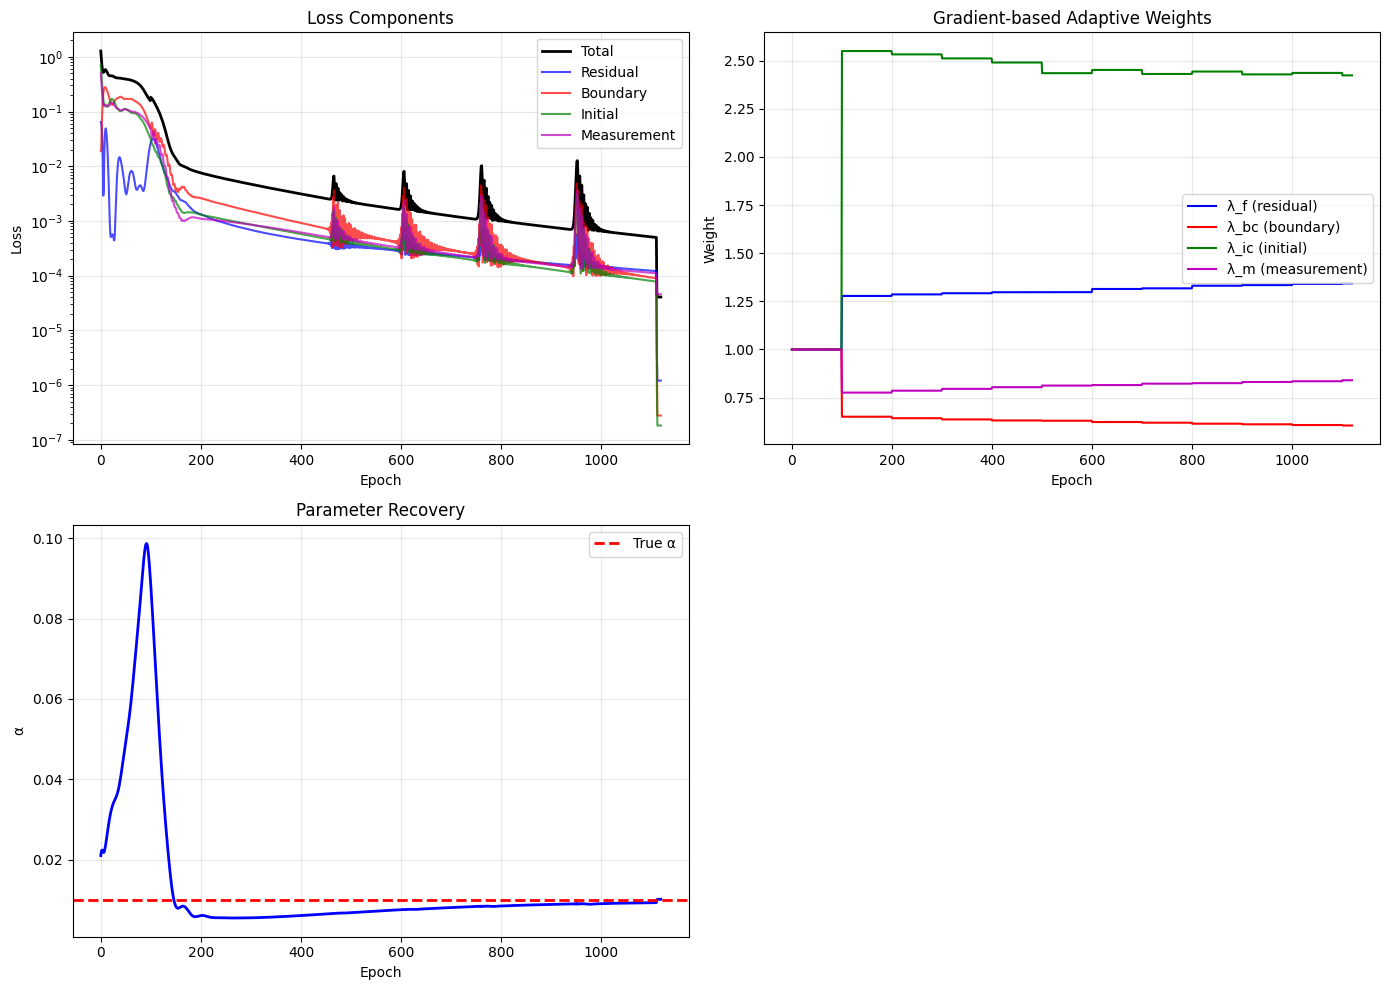


Training complete. Total time: 72.3s
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.0s)
  Total Loss: 1.094697e+00
  Residual: 8.520605e-02 (λ=1.00)
  Boundary: 1.710433e-02 (λ=1.00)
  Initial: 5.902013e-01 (λ=1.00)
  Measurement: 4.021853e-01 (λ=1.00)
  Alpha: 0.021000 (true: 0.01)

Switching to L-BFGS at epoch 1308

Final training plot:


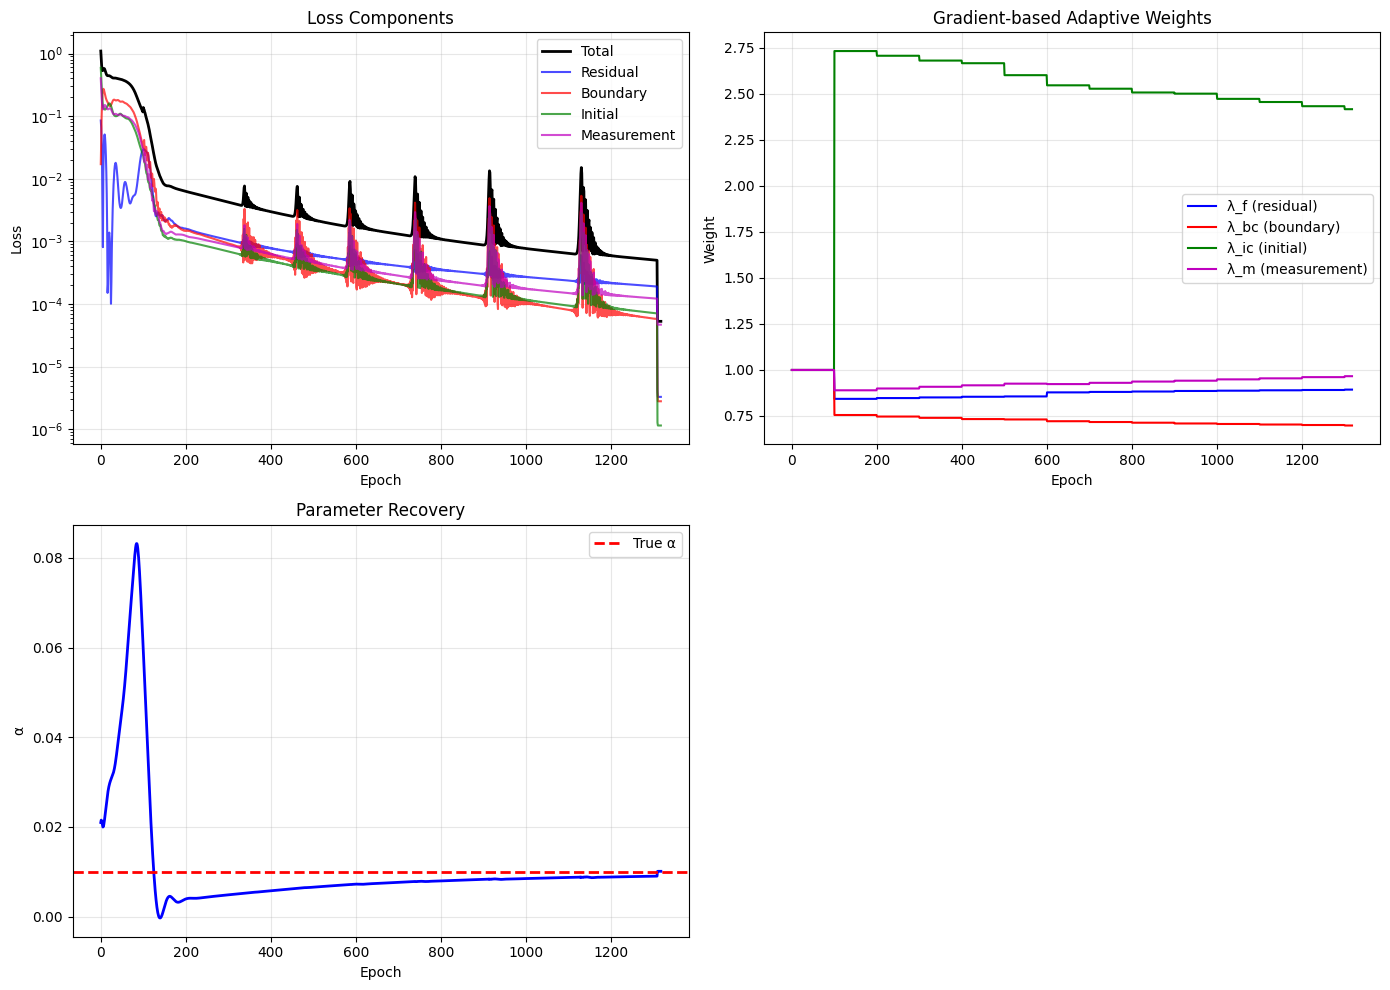


Training complete. Total time: 84.9s
α = 0.010089 ± 0.000027


In [33]:
# Train ensemble
results = []
for seed in range(10):
    torch.manual_seed(seed)
    model = HeatPINN(inverse=True, alpha_init=0.02)
    trainer = PINNTrainer(model, data, switch_threshold=5e-4, adaptive_weights=True)
    trainer.train(epochs=5000, print_every=2500, plot_every=5000)
    results.append(model.get_alpha())

alpha_mean = np.mean(results)
alpha_std = np.std(results)
print(f"α = {alpha_mean:.6f} ± {alpha_std:.6f}")

### Sensitivity to initial guess

Vary the starting guess for $\alpha$ and study its impact on parameter recovery


Starting alpha: 0.0050
Inverse problem mode: alpha initialized to 0.005
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.098324e+00
  Residual: 1.076626e-02 (λ=1.00)
  Boundary: 3.212563e-03 (λ=1.00)
  Initial: 5.874637e-01 (λ=1.00)
  Measurement: 4.968813e-01 (λ=1.00)
  Alpha: 0.006000 (true: 0.01)

Epoch 2500/5000 (139.4s)
  Total Loss: 4.086354e-03
  Residual: 3.275526e-05 (λ=1.72)
  Boundary: 1.193272e-05 (λ=0.66)
  Initial: 2.202957e-05 (λ=1.30)
  Measurement: 4.548220e-03 (λ=0.88)
  Alpha: 0.010691 (true: 0.01)

Final training plot:


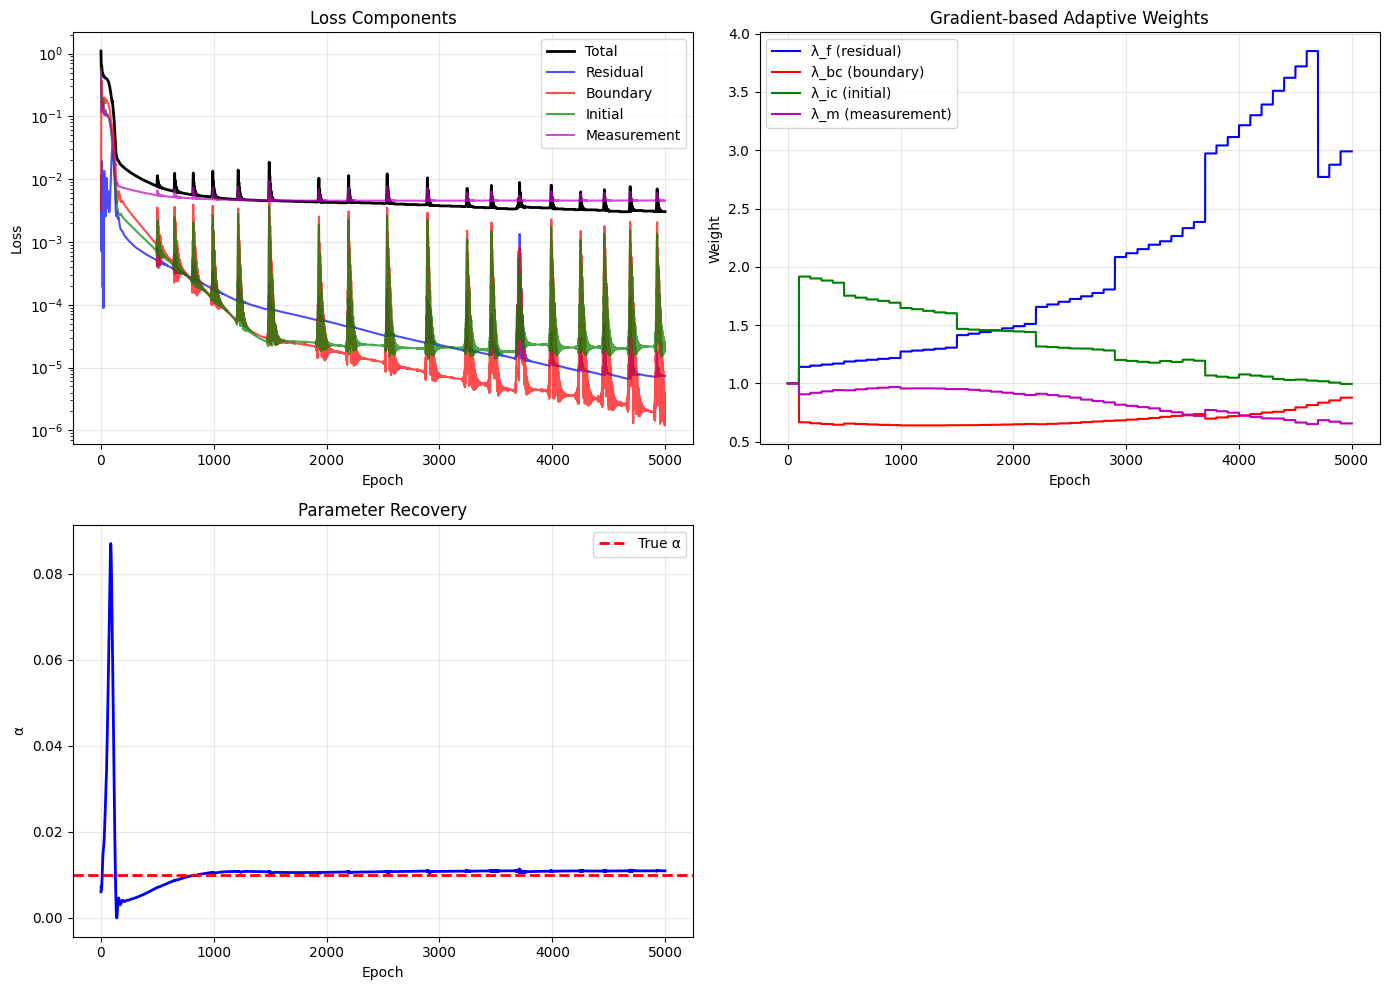


Training complete. Total time: 281.8s

Starting alpha: 0.0500
Inverse problem mode: alpha initialized to 0.05
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.240118e+00
  Residual: 1.749140e-03 (λ=1.00)
  Boundary: 1.098942e-02 (λ=1.00)
  Initial: 6.395474e-01 (λ=1.00)
  Measurement: 5.878324e-01 (λ=1.00)
  Alpha: 0.051000 (true: 0.01)

Epoch 2500/5000 (139.9s)
  Total Loss: 3.867067e-03
  Residual: 4.787647e-05 (λ=1.60)
  Boundary: 2.666642e-05 (λ=0.69)
  Initial: 2.774990e-05 (λ=1.49)
  Measurement: 4.639441e-03 (λ=0.80)
  Alpha: 0.010708 (true: 0.01)

Final training plot:


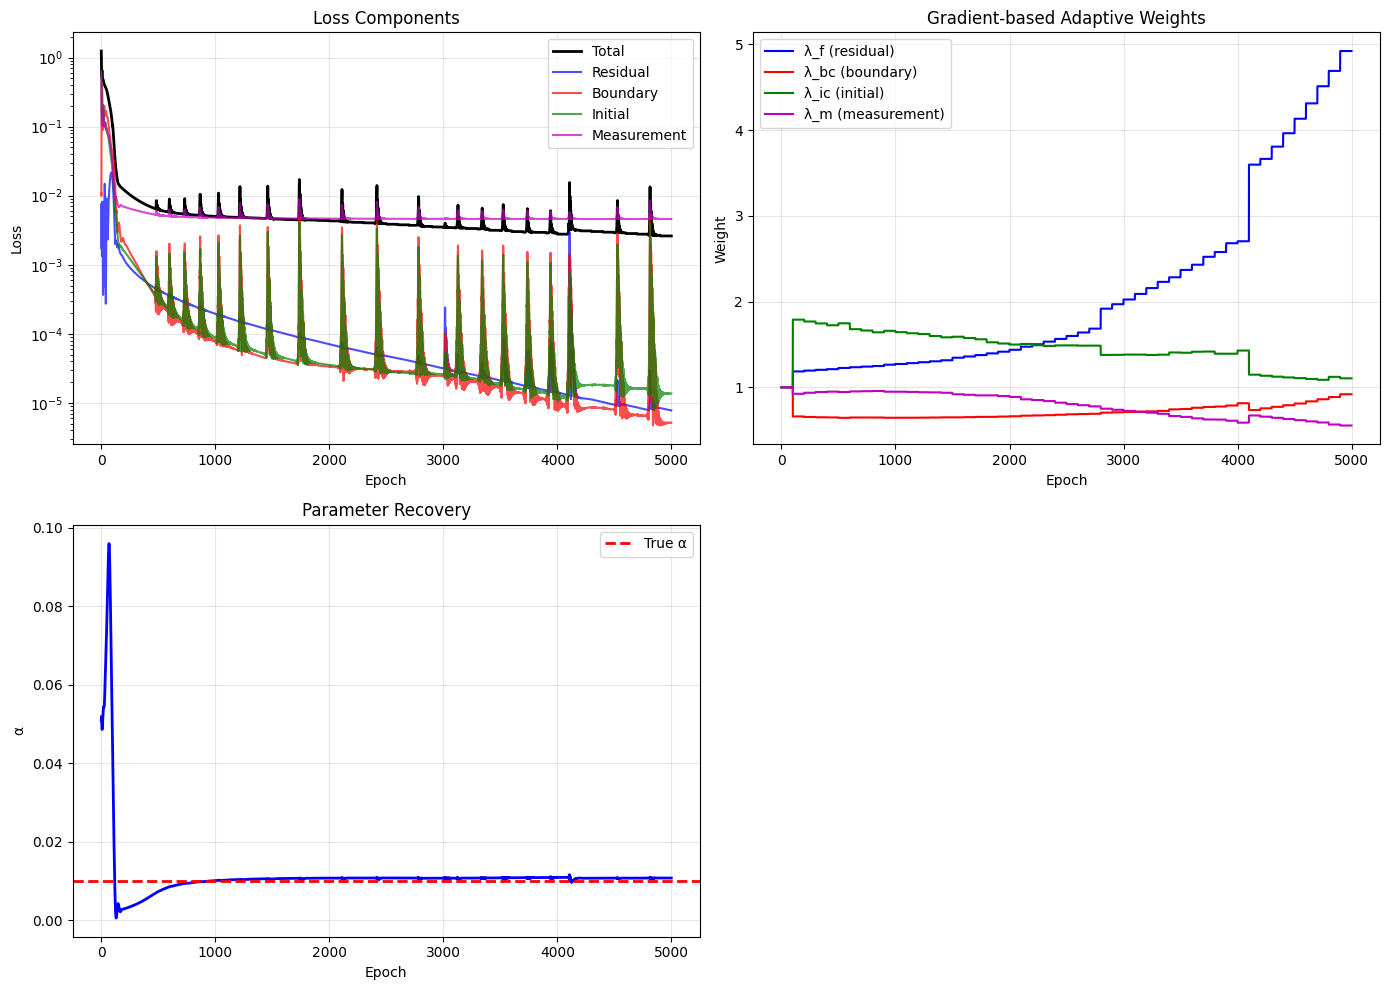


Training complete. Total time: 283.5s

Starting alpha: 0.5000
Inverse problem mode: alpha initialized to 0.5
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 6.563839e-01
  Residual: 1.132313e-03 (λ=1.00)
  Boundary: 6.458048e-02 (λ=1.00)
  Initial: 2.940585e-01 (λ=1.00)
  Measurement: 2.966126e-01 (λ=1.00)
  Alpha: 0.499000 (true: 0.01)

Epoch 2500/5000 (141.8s)
  Total Loss: 2.444414e-03
  Residual: 4.856541e-06 (λ=2.74)
  Boundary: 1.570441e-06 (λ=0.66)
  Initial: 2.113738e-06 (λ=4.45)
  Measurement: 4.607657e-03 (λ=0.53)
  Alpha: 0.011691 (true: 0.01)

Final training plot:


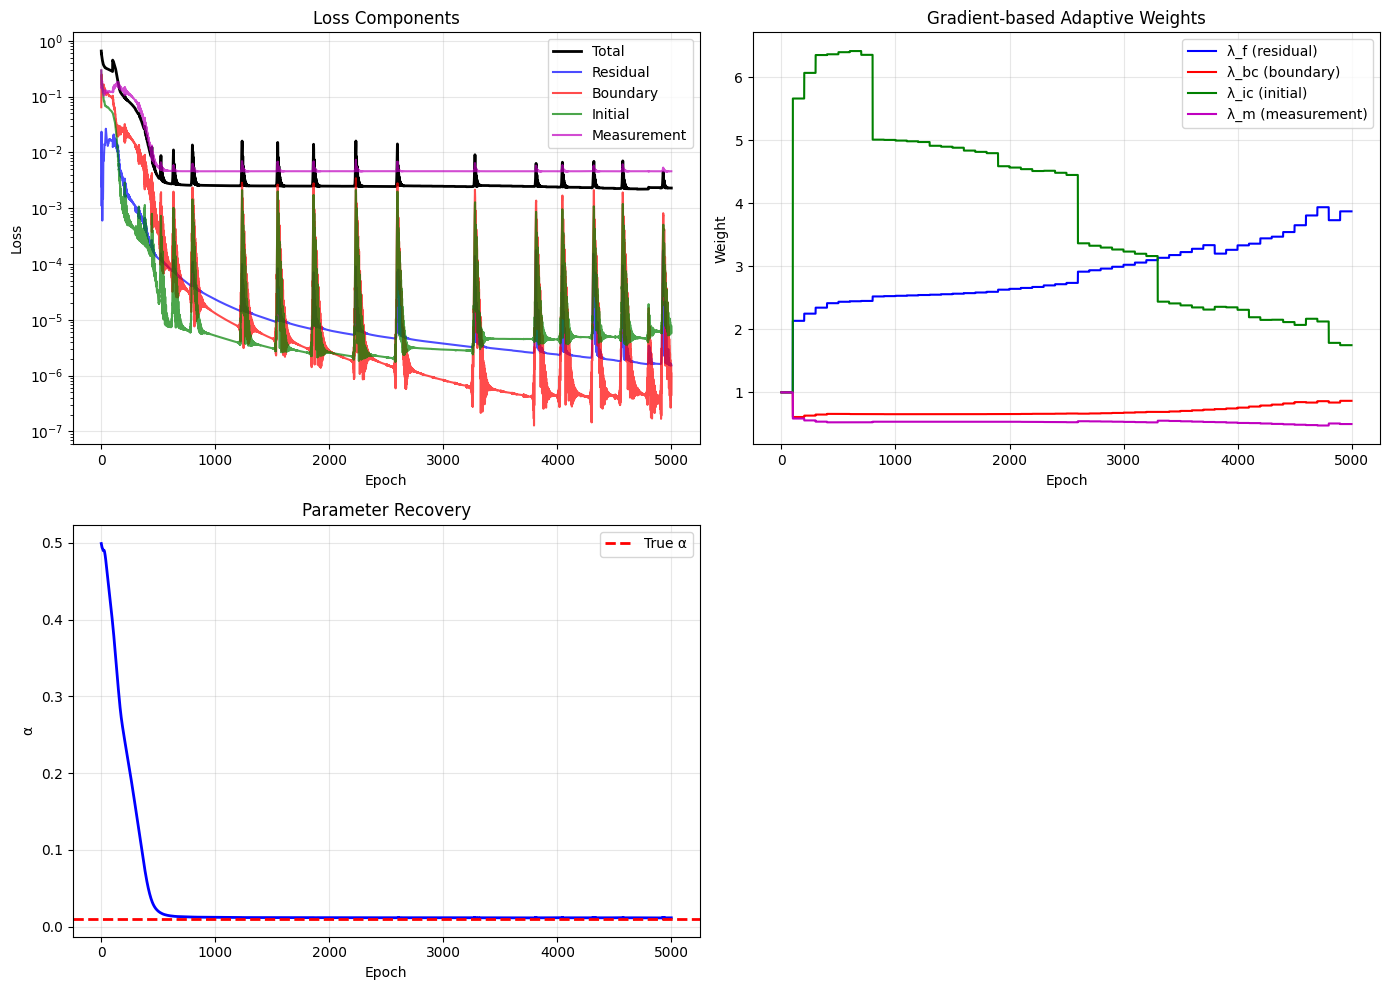


Training complete. Total time: 288.3s


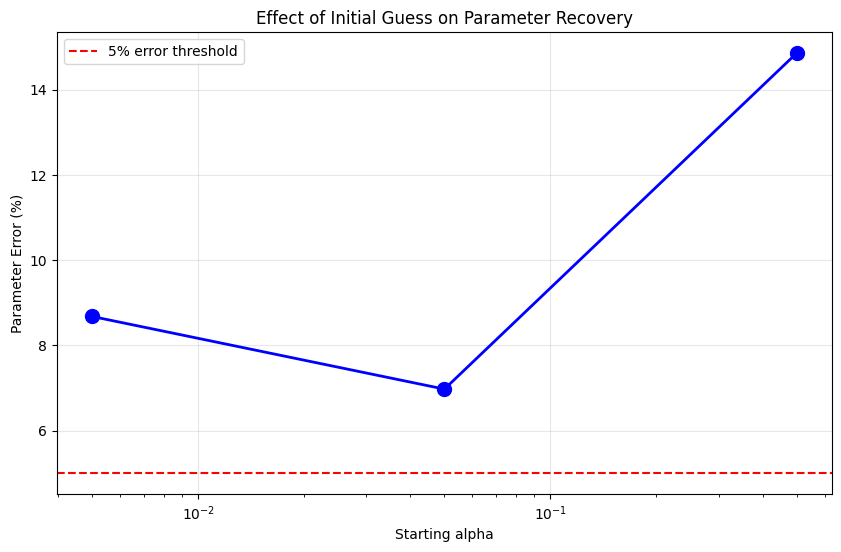

In [36]:
alpha_guesses = [0.005, 0.05, 0.5]
results = []

for alpha_guess in alpha_guesses:
    print(f"\nStarting alpha: {alpha_guess:.4f}")
    
    # Train inverse model for 5000 epochs
    model_temp = HeatPINN(inverse=True, alpha_init=alpha_guess)
    trainer_temp = PINNTrainer(model_temp, data_temp, learning_rate=1e-3, switch_threshold=5e-4, adaptive_weights=True)
    trainer_temp.train(epochs=5000, print_every=2500, plot_every=5000)

    # Record results
    alpha_recovered = model_temp.get_alpha()
    error = abs(alpha_recovered - 0.01) / 0.01 * 100
    results.append({
        'guess': alpha_guess,
        'alpha': alpha_recovered,
        'error': error
    })

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
guesses = [r['guess'] for r in results]
errors = [r['error'] for r in results]

ax.plot(guesses, errors, 'bo-', markersize=10, linewidth=2)
ax.axhline(y=5, color='r', linestyle='--', label='5% error threshold')
ax.set_xlabel('Starting alpha')
ax.set_ylabel('Parameter Error (%)')
ax.set_title('Effect of Initial Guess on Parameter Recovery')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

### Data requirements

Study the effect of low amount of measurements on parameter recovery


Number of sensors: 20.0
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 2 sensors × 10 times = 20 total
  Noise level: 10.0% (SNR ≈ 20 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.33333333 0.66666667]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 20
  Actual SNR: 20.5 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Total Loss: 1.739324e+00
  Residual: 3.763747e-04 (λ=1.00)
  Boundary: 4.342730e-0

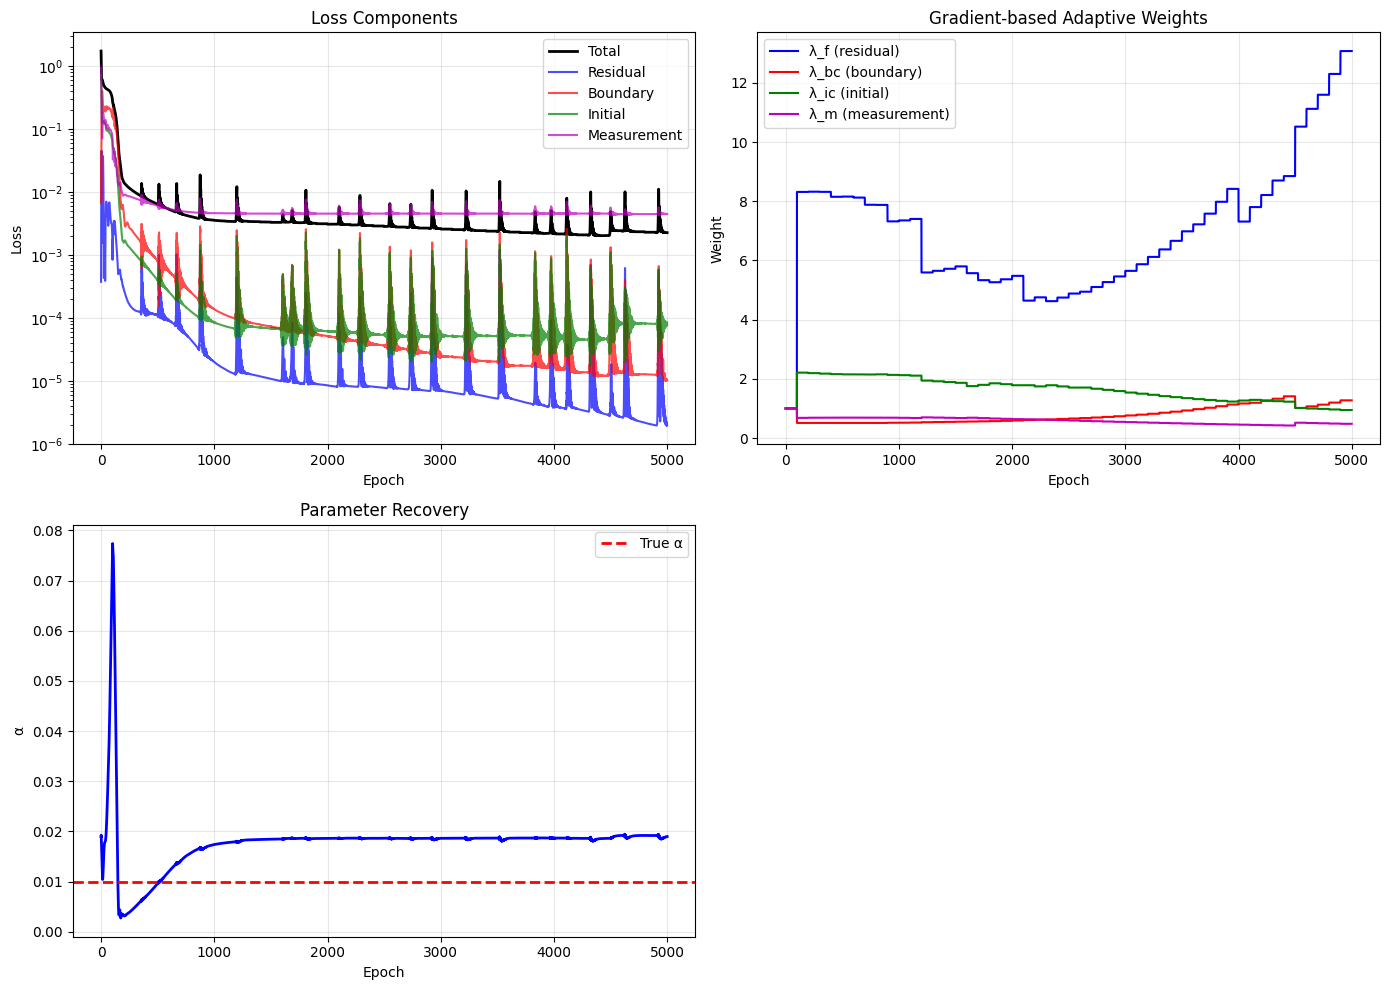


Training complete. Total time: 251.5s


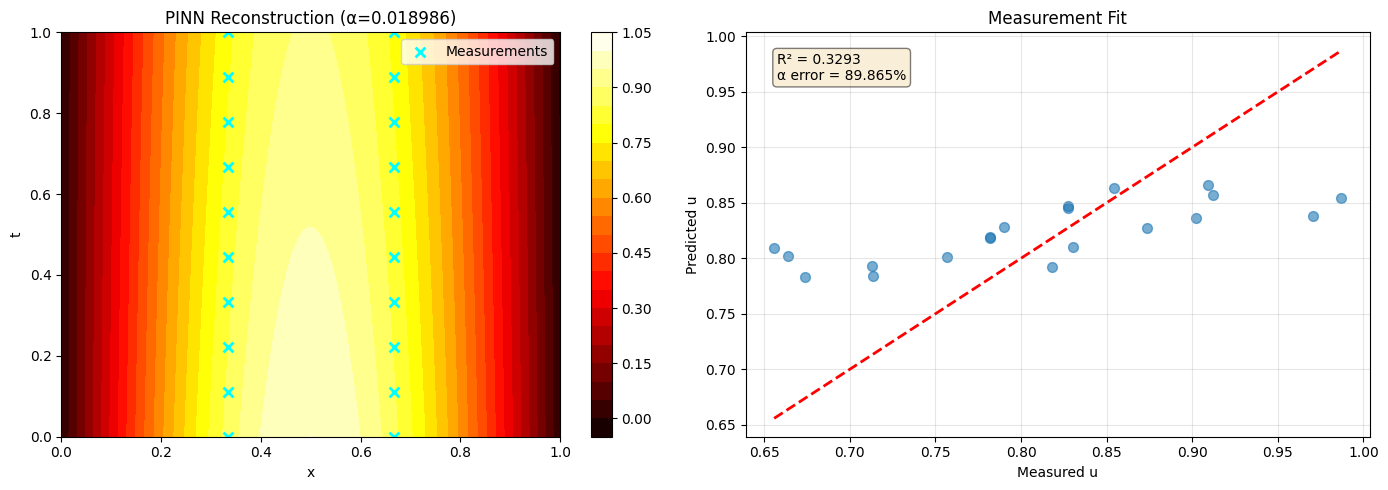


Number of sensors: 50.0
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 5 sensors × 10 times = 50 total
  Noise level: 10.0% (SNR ≈ 20 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.16666667 0.33333333 0.5        0.66666667 0.83333333]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 50
  Actual SNR: 20.5 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.0s)
  Total Loss: 1.566794e+00
  Residual: 3.763747e-04

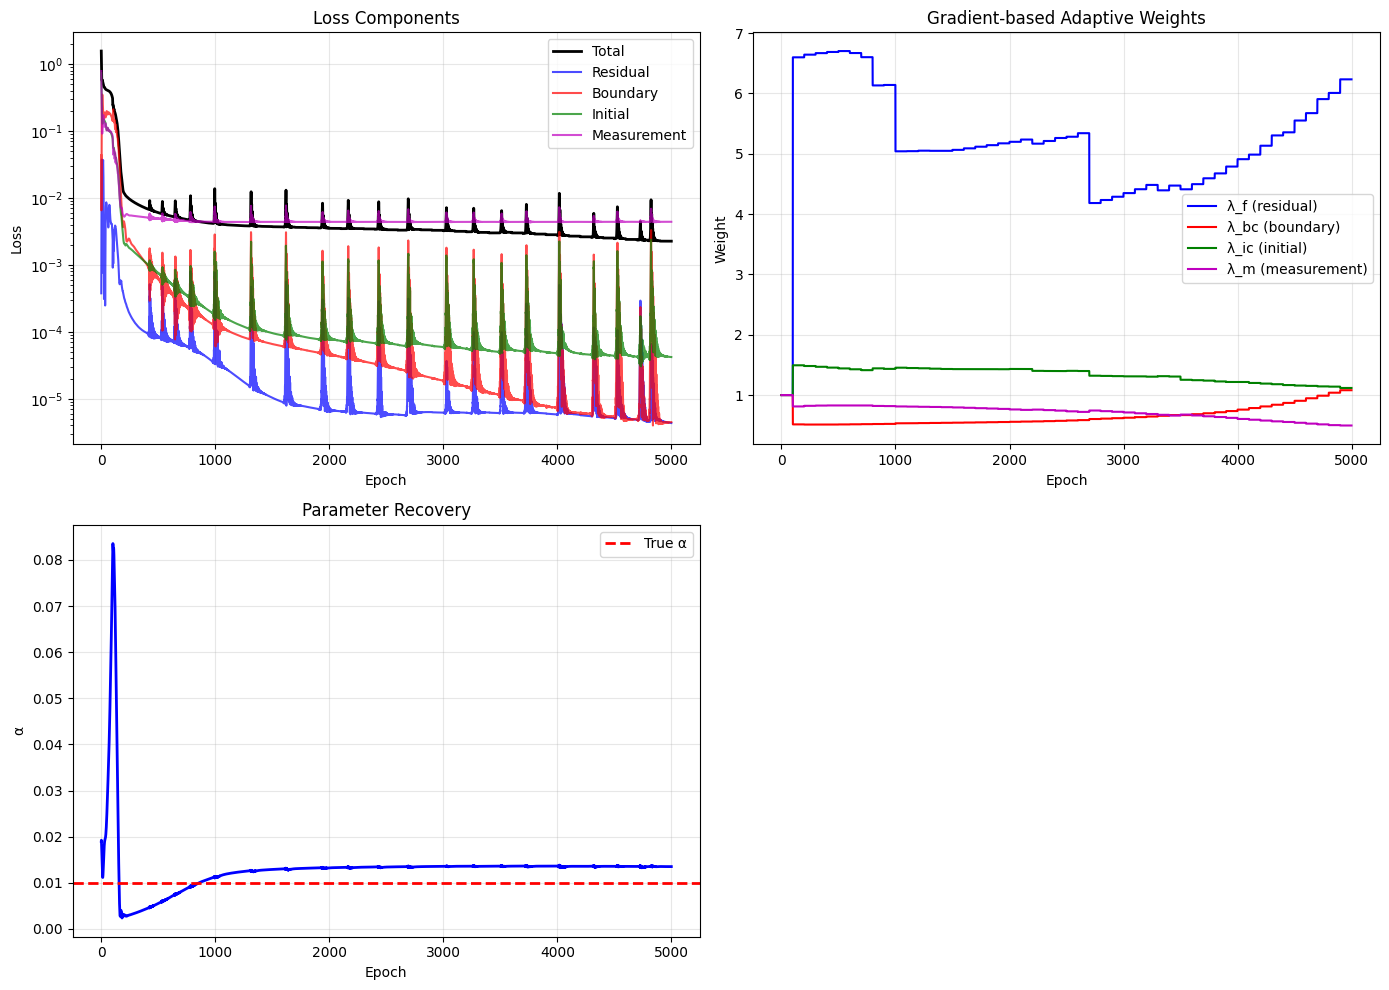


Training complete. Total time: 265.8s


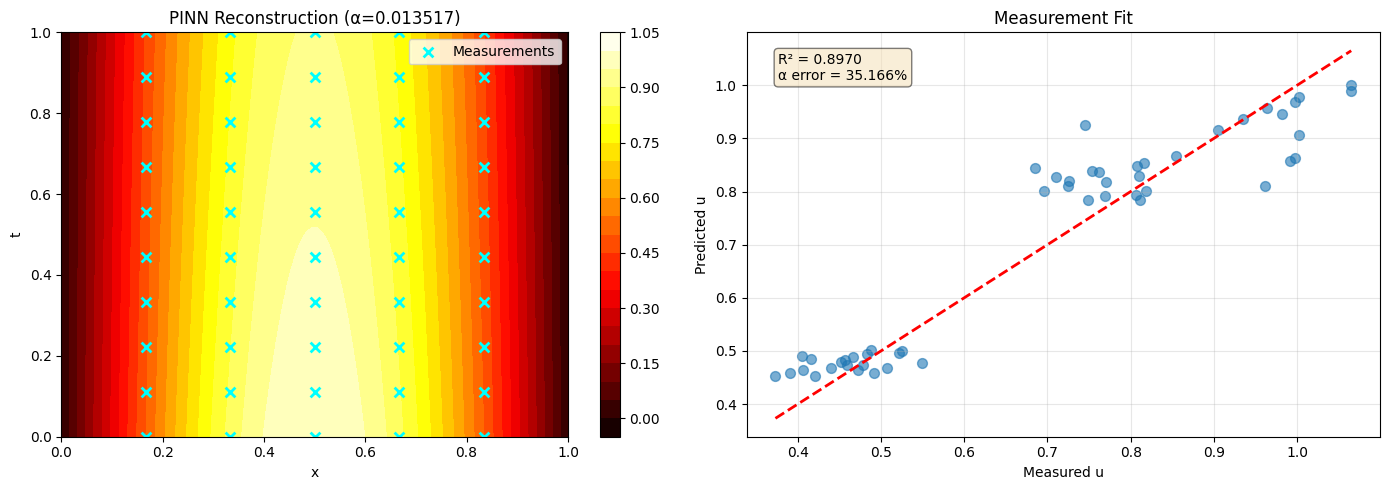


Number of sensors: 100.0
Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 10.0% (SNR ≈ 20 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 20.3 dB

Dataset generation complete.
Inverse problem mode: alpha initialized to 0.02
Trainer initialized:
  Device: cpu
  Adam Learning rate: 0.001
  Switch threshold for L-BFGS: 0.0005
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/500

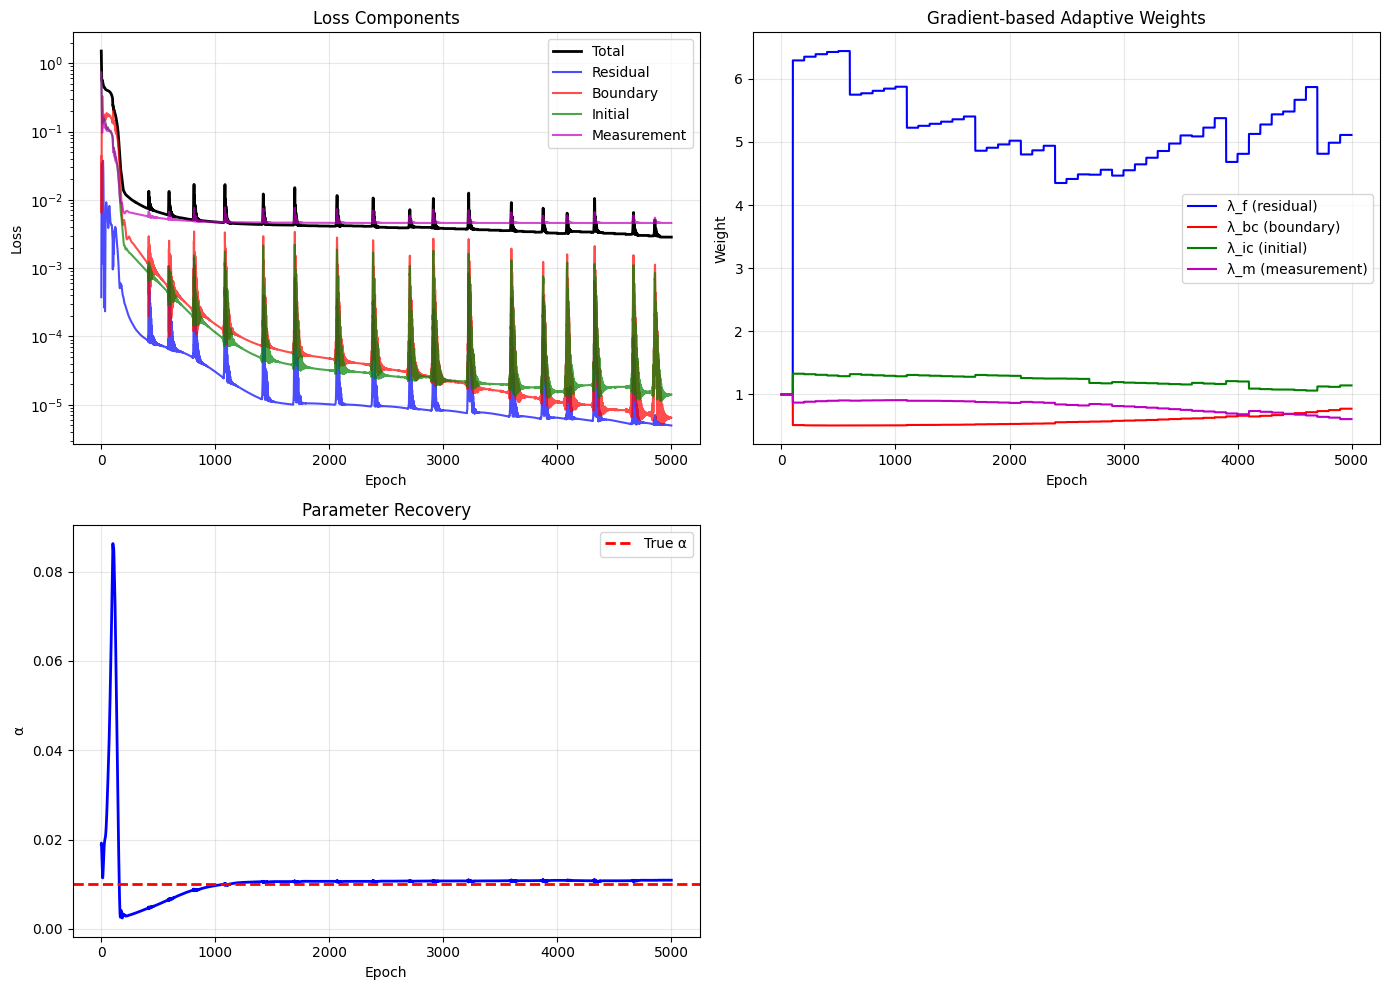


Training complete. Total time: 264.7s


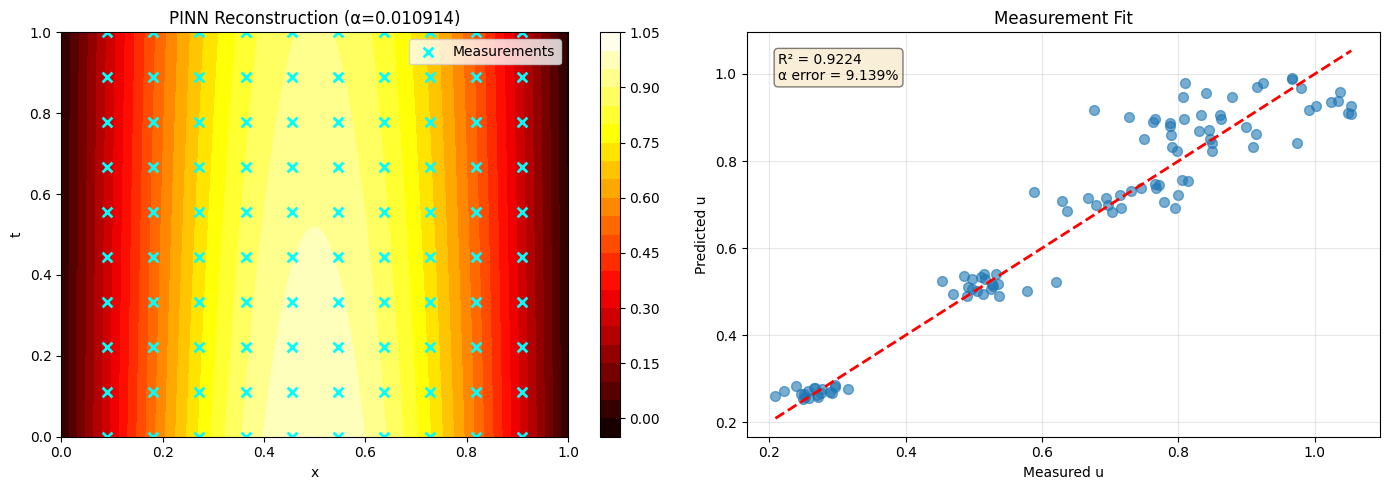

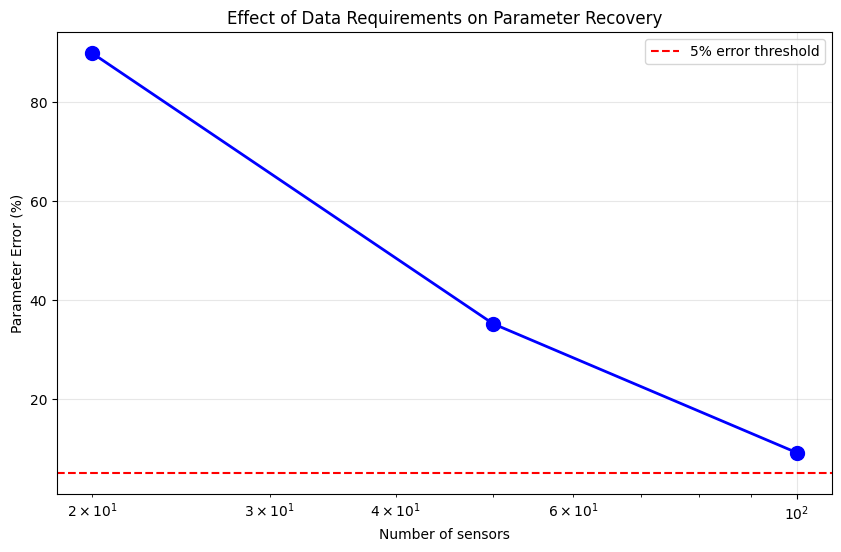

In [41]:
x_sensors = [2, 5, 10]
t_sensors = 10
results = []

for sensor in x_sensors:
    print(f"\nNumber of sensors: {sensor * t_sensors:.1f}")
    
    # Generate new data with different noise levels
    data_gen_temp = HeatEquationData(
        N_f=10000, 
        N_bc=100,
        N_ic=200,
        N_sensors=sensor,
        N_time_measurements=t_sensors,
        noise_level=noise, 
        device='cpu'
    )
    data_temp = data_gen_temp.generate_full_dataset()
    
    # Train inverse model for 5000 epochs
    model_temp = HeatPINN(inverse=True, alpha_init=0.02)
    trainer_temp = PINNTrainer(model_temp, data_temp, learning_rate=1e-3, switch_threshold=5e-4, adaptive_weights=True)
    trainer_temp.train(epochs=5000, print_every=2500, plot_every=5000)
    
    # Record results
    alpha_recovered = model_temp.get_alpha()
    error = abs(alpha_recovered - 0.01) / 0.01 * 100
    results.append({
        'n_sensors': sensor * t_sensors,
        'alpha': alpha_recovered,
        'error': error
    })

    # Plot reconstructed solution
    x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
    t_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
    X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

    x_flat = X.flatten().reshape(-1, 1)
    t_flat = T.flatten().reshape(-1, 1)

    u_pred_inv = model_inverse.predict(x_flat, t_flat).reshape(100, 100)

    x_m = data_temp['x_m'].cpu().numpy()
    t_m = data_temp['t_m'].cpu().numpy()
    u_m = data_temp['u_m'].cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Reconstructed solution with measurements
    im1 = axes[0].contourf(X.numpy(), T.numpy(), u_pred_inv, levels=20, cmap='hot')
    axes[0].scatter(x_m, t_m, c='cyan', s=50, marker='x', linewidths=2, label='Measurements')
    axes[0].set_title(f'PINN Reconstruction (α={alpha_recovered:.6f})')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('t')
    axes[0].legend()
    plt.colorbar(im1, ax=axes[0])

    # Plot 2: Measurement fit
    u_m_pred = model_inverse.predict(data_temp['x_m'], data_temp['t_m'])
    axes[1].scatter(u_m, u_m_pred, alpha=0.6, s=50)
    axes[1].plot([u_m.min(), u_m.max()], [u_m.min(), u_m.max()], 'r--', linewidth=2)
    axes[1].set_xlabel('Measured u')
    axes[1].set_ylabel('Predicted u')
    axes[1].set_title('Measurement Fit')
    axes[1].grid(True, alpha=0.3)

    r2 = 1 - np.sum((u_m - u_m_pred)**2) / np.sum((u_m - u_m.mean())**2)
    axes[1].text(0.05, 0.95, f'R² = {r2:.4f}\nα error = {error:.3f}%', 
            transform=axes[1].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
n_sensors = [r['n_sensors'] for r in results]
errors = [r['error'] for r in results]

ax.plot(n_sensors, errors, 'bo-', markersize=10, linewidth=2)
ax.axhline(y=5, color='r', linestyle='--', label='5% error threshold')
ax.set_xlabel('Number of sensors')
ax.set_ylabel('Parameter Error (%)')
ax.set_title('Effect of Data Requirements on Parameter Recovery')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()